# Multiome analysis

## Libraries and misc data

In [1]:
import snapatac2 as snap
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import pandas as pd
import numpy as np
import re
import gc
import matplotlib.pyplot as plt
from pybedtools import BedTool

### Functions

In [2]:
def grouped_obs_sum(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.sum(axis=0, dtype=np.float64))
    return out

## Read in raw data

In [2]:
lib_dict = {}

for i in range(13,21):
    tmp_dict = {"M" + str(i) : "M13_M20"}
    lib_dict.update(tmp_dict)

for i in range(21,37):
    tmp_dict = {"M" + str(i) : "M21_M36"}
    lib_dict.update(tmp_dict)
    
for i in range(37,49):
    tmp_dict = {"M" + str(i) : "M37_M48"}
    lib_dict.update(tmp_dict)
    
for i in range(49,51):
    tmp_dict = {"M" + str(i) : "M49_M50"}
    lib_dict.update(tmp_dict)
    
for i in range(51,61):
    tmp_dict = {"M" + str(i) : "M51_M60"}
    lib_dict.update(tmp_dict)
    
for i in range(61,65):
    tmp_dict = {"M" + str(i) : "M61_M64"}
    lib_dict.update(tmp_dict)

In [3]:
lib_df = pd.DataFrame({'library' : lib_dict.keys(),
                       'lib_group' : lib_dict.values()})

In [4]:
# lib_df = pd.DataFrame({'start' : [13,21,37,49,51,61],
#                        'end' : [20,36,48,50,60,64],
#                        'lib_group' : ["M13_M20","M21_M36","M37_M48","M49_M50","M51_M60","M61_M64"]})

## Process ATAC and RNA data

### Subset ATAC

These files have had 'add_tile_matrix' run on them

In [4]:
libs = range(13,65)

In [5]:
# read in ATAC files
atac_files = [("MRA{}".format(i), "write/MA{}.h5ad".format(i)) for i in libs]
atacs = [snap.read(filename=file) for _, file in atac_files]

In [8]:
%%time
atac = snap.AnnDataSet(
    adatas=[(name, atac) for (name, _), atac in zip(atac_files, atacs)],
    filename="write/MA_all.h5ads"
)

CPU times: user 6.24 s, sys: 670 ms, total: 6.91 s
Wall time: 7.54 s


In [14]:
# make unique IDs
unique_cell_ids = [sa + ':' + bc for sa, bc in zip(atac.obs['sample'], atac.obs_names)]
atac.obs_names = unique_cell_ids
assert atac.n_obs == np.unique(atac.obs_names).size

/tmp/ipykernel_303668/1168813762.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  unique_cell_ids = [sa + ':' + bc for sa, bc in zip(atac.obs['sample'], atac.obs_names)]


Read in pre-processed RNA-seq files

In [8]:
rnas = dict(zip(["MRA" + str(lib) for lib in libs], [None]*len(libs)))

In [16]:
for lib in libs:
    rna_path = "write/MR{}.h5ad".format(lib)
    rnas["MRA" + str(lib)] = sc.read_h5ad(rna_path)

In [17]:
for sa, rna in rnas.items():
    rna.obs_names = sa + ":" + rna.obs_names

In [18]:
rna = ad.concat(rnas)

In [64]:
# get shared barcodes
bc_overlap = list(set(rna.obs_names).intersection(set(atac.obs_names)))

In [ ]:
# subset ATAC data to those cells shared by processed ATAC and RNA
atac = atac.subset(obs_indices = bc_overlap, out="write")

### Subset RNA

Clear kernel here and read in ATAC and RNA data again, this time subsetting RNA data and writing out the anndata object

In [4]:
libs = range(13,65)

In [5]:
# read in ATAC files
atac_files = [("MRA{}".format(i), "write/anndatas/MRA{}.h5ad".format(i)) for i in libs]
atacs = [snap.read(filename=file) for _, file in atac_files]

In [6]:
%%time
atac = snap.AnnDataSet(
    adatas=[(name, atac) for (name, _), atac in zip(atac_files, atacs)],
    filename="write/anndatas/MRA_all.h5ads"
)

CPU times: user 5.95 s, sys: 611 ms, total: 6.56 s
Wall time: 6.94 s


In [7]:
# make unique IDs
unique_cell_ids = [sa + ':' + bc for sa, bc in zip(atac.obs['sample'], atac.obs_names)]
atac.obs_names = unique_cell_ids
assert atac.n_obs == np.unique(atac.obs_names).size

/tmp/ipykernel_220714/1168813762.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  unique_cell_ids = [sa + ':' + bc for sa, bc in zip(atac.obs['sample'], atac.obs_names)]


In [8]:
rnas = dict(zip(["MRA" + str(lib) for lib in libs], [None]*len(libs)))

In [9]:
for lib in libs:
    rna_path = "write/MR{}.h5ad".format(lib)
    rnas["MRA" + str(lib)] = sc.read_h5ad(rna_path)

In [10]:
for sa, rna in rnas.items():
    rna.obs_names = sa + ":" + rna.obs_names

In [19]:
rnas['MRA28'].obs_names

Index(['MRA28:AAACAGCCAAGTGTTT-1', 'MRA28:AAACAGCCAATTGAAG-1',
       'MRA28:AAACAGCCACAAACTT-1', 'MRA28:AAACAGCCACGTGCTG-1',
       'MRA28:AAACAGCCACTATGGC-1', 'MRA28:AAACAGCCACTTGTTC-1',
       'MRA28:AAACAGCCAGGCCAAA-1', 'MRA28:AAACAGCCATAATCGT-1',
       'MRA28:AAACAGCCATAATGAG-1', 'MRA28:AAACAGCCATCAATCG-1',
       ...
       'MRA28:TTTGTGTTCTTTGACT-1', 'MRA28:TTTGTTGGTAGTAAGA-1',
       'MRA28:TTTGTTGGTAGTTGGC-1', 'MRA28:TTTGTTGGTCACAAAT-1',
       'MRA28:TTTGTTGGTCTATCGT-1', 'MRA28:TTTGTTGGTGCGCGTA-1',
       'MRA28:TTTGTTGGTGGAAGGC-1', 'MRA28:TTTGTTGGTGGTTATG-1',
       'MRA28:TTTGTTGGTTAAGCCA-1', 'MRA28:TTTGTTGGTTCACTGT-1'],
      dtype='object', length=14406)

In [20]:
rna_raw = ad.concat(rnas)

In [12]:
# get shared barcodes
bc_overlap = list(set(rna_raw.obs_names).intersection(set(atac.obs_names)))

In [23]:
len(set(rna_raw.obs_names).intersection(set(bc_overlap)))

648402

In [24]:
# subset RNA data
rna_raw = rna_raw[bc_overlap,:]

In [25]:
rna_raw.write("write/MR_all_raw.h5ad")

In [26]:
rna = rna_raw

### Add covariate information to RNA and ATAC

In [4]:
libs = range(13,65)

In [5]:
rna = sc.read_h5ad("write/MR_all_raw.h5ad")

AnnData object with n_obs × n_vars = 648402 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'donor_id'

In [44]:
# read in ATAC files
atac_files = [("MRA{}".format(i), "write/anndatas/MRA{}.h5ad".format(i)) for i in libs]
atacs = [snap.read(filename=file) for _, file in atac_files]

In [45]:
atac = snap.AnnDataSet(
    adatas=[(name, atac) for (name, _), atac in zip(atac_files, atacs)],
    filename="MA_all.h5ads"
)

In [46]:
atac

AnnDataSet object with n_obs x n_vars = 648402 x 6062095 backed at 'MA_all.h5ads'
contains 52 AnnData objects with keys: 'MRA13', 'MRA14', 'MRA15', 'MRA16', 'MRA17', 'MRA18', 'MRA19', 'MRA20', 'MRA21', 'MRA22', 'MRA23', 'MRA24', 'MRA25', 'MRA26', 'MRA27', 'MRA28', 'MRA29', 'MRA30', 'MRA31', 'MRA32', 'MRA33', 'MRA34', 'MRA35', 'MRA36', 'MRA37', 'MRA38', 'MRA39', 'MRA40', 'MRA41', 'MRA42', 'MRA43', 'MRA44', 'MRA45', 'MRA46', 'MRA47', 'MRA48', 'MRA49', 'MRA50', 'MRA51', 'MRA52', 'MRA53', 'MRA54', 'MRA55', 'MRA56', 'MRA57', 'MRA58', 'MRA59', 'MRA60', 'MRA61', 'MRA62', 'MRA63', 'MRA64'
    obs: 'sample'
    uns: 'AnnDataSet', 'reference_sequences'

In [ ]:
#atac_set.obsm['fragment_paired'] = atac_set.adatas.obsm['fragment_paired']

In [ ]:
#atac_set.adatas.obsm['fragment_paired'].shape

In [ ]:
#atac = atac_set.to_adata()

In [50]:
# make unique IDs
unique_cell_ids = [sa + ':' + bc for sa, bc in zip(atac.obs['sample'], atac.obs_names)]
atac.obs_names = unique_cell_ids
assert atac.n_obs == np.unique(atac.obs_names).size

/tmp/ipykernel_168257/1168813762.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  unique_cell_ids = [sa + ':' + bc for sa, bc in zip(atac.obs['sample'], atac.obs_names)]


In [16]:
id_cond_raw = pd.read_csv("misc/lib.id.cond.tsv", names=("BATCH","LIBRARY","S1","S2","S3","S4","S5","S6","S7","S8"), sep="\t")
sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")
sample_info = sample_info_raw[['ID:lab', 'ID:field', 'ID:topmed', 'Subject_Information:Sex::str', 'Subject_Information:Age::num::yr', 'Subject_Information:Ethnicity::str']] \
    .rename(columns={"ID:lab":"LID",
                     "ID:field":"FID",
                     "ID:topmed":"TID",
                     "Subject_Information:Sex::str": "SEX",
                     "Subject_Information:Age::num::yr": "AGE",
                     "Subject_Information:Ethnicity::str": "POP"})

/tmp/ipykernel_168257/1794144177.py:2: DtypeWarning: Columns (4,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,130,131,132,133,134,135,136,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,185,187,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")


In [20]:
# format id_cond_raw so that every unique library and sample combo is a different line
id_cond = id_cond_raw.melt(id_vars = ["BATCH","LIBRARY"]).drop('variable', axis=1)
id_cond = id_cond[~id_cond['value'].isna()]

In [21]:
# split the 'FID COND' combos into separate columns
id_cond[['FID','COND']] = id_cond['value'].str.split(' ', expand=True)
id_cond = id_cond.reset_index().drop(['index','value'], axis=1)

In [22]:
# add TOPMed ID and covariate information to id_cond for easier merging with ambimux output
id_cond[['FID','LID','TID','SEX','AGE','POP']] = id_cond[['FID']].merge(sample_info)

In [23]:
# rename the ethnicity information
pop_map = {'TIKARI':'Tikari',
           'MBORORO FULANI':'Fulani',
           'MBORORO':'Fulani',
           'FULANI':'Fulani',
           'KIERIJO':'Fulani'}

In [24]:
# group ethnicities together
id_cond['Ethnicity'] = id_cond['POP'].apply(lambda x: pop_map[x])

In [25]:
id_cond['LIBRARY'] = id_cond['LIBRARY'].apply(lambda x: re.sub("R","RA",x))

In [18]:
id_cond.to_csv("misc/lib.id.cond.clean.tsv", sep="\t", index=False)

In [26]:
# read in ambimux data for assigning the sample ID
ambimuxs = []
for lib in libs:
    ambimux = pd.read_csv("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(lib,lib), sep="\t", index_col=0)
    ambimux = ambimux[~ambimux['best_type'].isin(['Empty','Doublet'])]
    ambimux['LIBRARY'] = "MRA" + str(lib)
    ambimuxs.append(ambimux)

In [27]:
ambimux = pd.concat(ambimuxs)

In [28]:
# change barcodes to merge with ATAC and RNA anndata objects
ambimux = ambimux.reset_index()
ambimux['Barcode'] = ambimux['LIBRARY'].astype(str) + ":" + ambimux['Barcode'].astype(str)

In [29]:
ambimux = ambimux.set_index('Barcode')

In [20]:
ambimux.to_csv("misc/ambimux_singlets.txt", sep="\t")

Add covariate data to ATAC

In [51]:
# create dataframe of covariate information to save in atac 
atac_covars = ambimux.loc[atac.obs_names,['LIBRARY','best_singlet']].rename(columns={'best_singlet':'TID'}).merge(id_cond)

In [52]:
atac.obs['TID'] = atac_covars['TID']
atac.obs['FID'] = atac_covars['FID']
atac.obs['BATCH'] = atac_covars['BATCH']
atac.obs['COND'] = atac_covars['COND']
atac.obs['SEX'] = atac_covars['SEX']
atac.obs['AGE'] = atac_covars['AGE']
atac.obs['Ethnicity'] = atac_covars['Ethnicity']

In [54]:
atac

AnnDataSet object with n_obs x n_vars = 648402 x 6062095 backed at 'MA_all.h5ads'
contains 52 AnnData objects with keys: 'MRA13', 'MRA14', 'MRA15', 'MRA16', 'MRA17', 'MRA18', 'MRA19', 'MRA20', 'MRA21', 'MRA22', 'MRA23', 'MRA24', 'MRA25', 'MRA26', 'MRA27', 'MRA28', 'MRA29', 'MRA30', 'MRA31', 'MRA32', 'MRA33', 'MRA34', 'MRA35', 'MRA36', 'MRA37', 'MRA38', 'MRA39', 'MRA40', 'MRA41', 'MRA42', 'MRA43', 'MRA44', 'MRA45', 'MRA46', 'MRA47', 'MRA48', 'MRA49', 'MRA50', 'MRA51', 'MRA52', 'MRA53', 'MRA54', 'MRA55', 'MRA56', 'MRA57', 'MRA58', 'MRA59', 'MRA60', 'MRA61', 'MRA62', 'MRA63', 'MRA64'
    obs: 'sample', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity'
    uns: 'AnnDataSet', 'reference_sequences'

In [55]:
atac.close()

In [63]:
rna_covars = ambimux.loc[rna.obs_names,['LIBRARY','best_singlet']].reset_index().rename(columns={'best_singlet':'TID'}).merge(id_cond).set_index('index')

In [66]:
rna.obs[['TID','FID','BATCH','COND','SEX','AGE','Ethnicity']] = rna_covars[['TID','FID','BATCH','COND','SEX','AGE','Ethnicity']]

In [68]:
rna.write("write/MR_all_raw.h5ad")

... storing 'TID' as categorical
... storing 'FID' as categorical
... storing 'BATCH' as categorical
... storing 'COND' as categorical
... storing 'SEX' as categorical
... storing 'Ethnicity' as categorical


### Normalize and select features for dimensionality reduction

In [24]:
snap.pp.select_features(atac, n_features=50000)

2025-05-12 23:09:06 - INFO - Selected 50000 features.


In [44]:
sc.pp.highly_variable_genes(rna, flavor='seurat_v3', n_top_genes=5000)
rna = rna[:, rna.var.highly_variable]

In [45]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning:

Received a view of an AnnData. Making a copy.



In [25]:
# ATAC-seq embedding and UMAP
snap.tl.spectral(atac)

In [26]:
snap.tl.umap(atac)

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


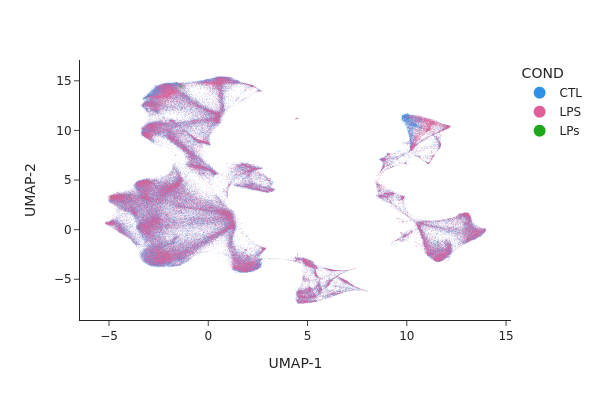

In [27]:
snap.pl.umap(atac, color="COND", interactive=False)

In [46]:
snap.tl.spectral(rna, features=None)
snap.tl.umap(rna)

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



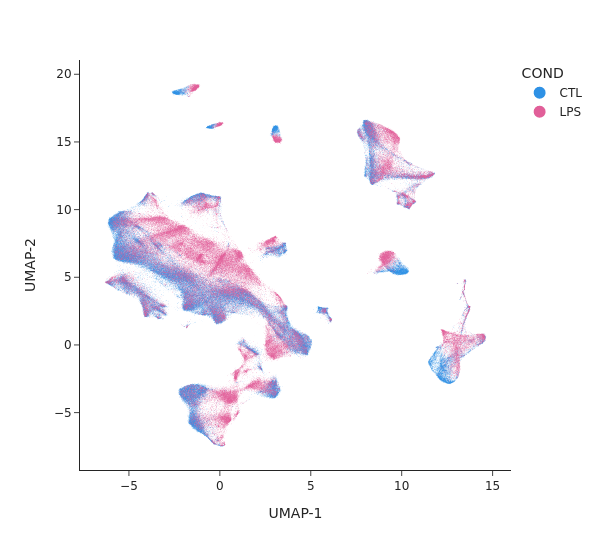

In [47]:
snap.pl.umap(rna, color='COND', interactive=False, height=550)

In [48]:
rna.write("write/MR_all.h5ad")

... storing 'TID' as categorical
... storing 'FID' as categorical
... storing 'BATCH' as categorical
... storing 'COND' as categorical
... storing 'SEX' as categorical
... storing 'Ethnicity' as categorical


In [29]:
atac.close()

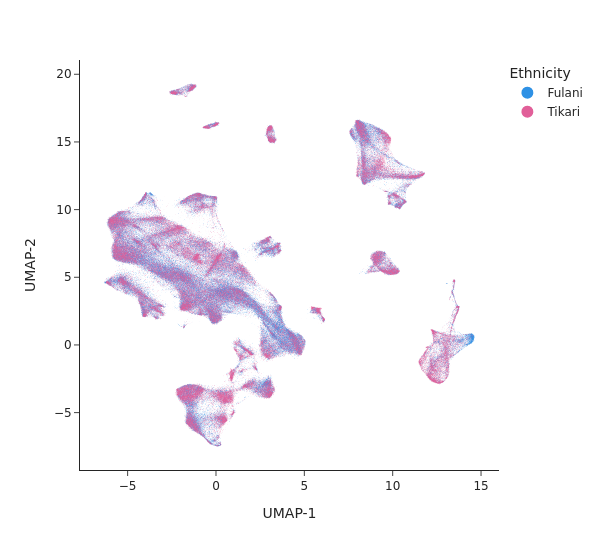

In [49]:
snap.pl.umap(rna, color='Ethnicity', interactive=False, height=550)

### Assign cell lineages to RNA-seq

First separate CTL and LPS conditions

In [36]:
rna = sc.read_h5ad("write/MR_all_raw.h5ad")

In [69]:
rna_ctl = rna[rna.obs['COND']=="CTL"]

In [70]:
rna_lps = rna[rna.obs['COND']=="LPS"]

In [73]:
rna_ctl.write("write/MR_ctl_raw.h5ad")
rna_lps.write("write/MR_lps_raw.h5ad")

I am going to run `/project/tishkofflab/projects/SingleCellRNA/scripts/scrnaseq/project_umap.from_raw.multiome.py` on each of these files

In [3]:
rna_ctl = sc.read_h5ad("write/MR_ctl_raw.umap.h5ad")
rna_lps = sc.read_h5ad("write/MR_lps_raw.umap.h5ad")

In [5]:
rna_ctl.var["ribo"] = rna_ctl.var_names.str.startswith(("RPS", "RPL"))
rna_lps.var["ribo"] = rna_lps.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(
    rna_ctl, qc_vars=["ribo"], inplace=True, log1p=True
)
sc.pp.calculate_qc_metrics(
    rna_lps, qc_vars=["ribo"], inplace=True, log1p=True
)

2025-05-21 19:12:50 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:50 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:50 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:52 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:53 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

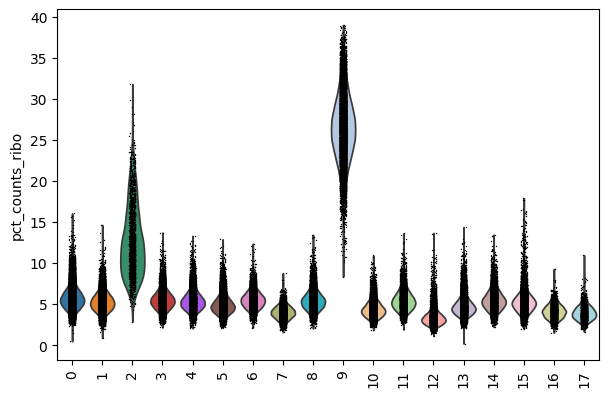

2025-05-21 19:12:54 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:54 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:54 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:56 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-21 19:12:57 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

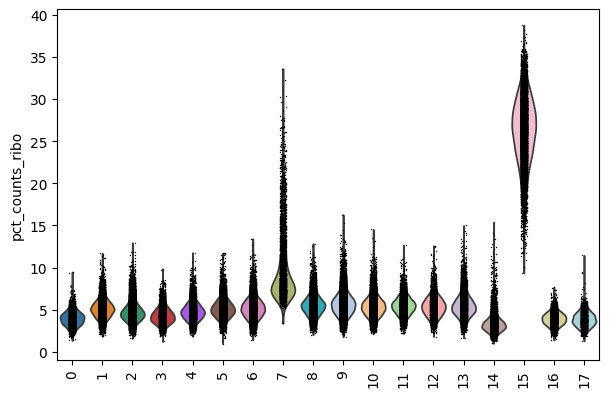

In [6]:
sc.pl.violin(rna_ctl, keys='pct_counts_ribo', groupby='leiden', rotation=90)
sc.pl.violin(rna_lps, keys='pct_counts_ribo', groupby='leiden', rotation=90)

In [7]:
ctypes_ctl = pd.read_csv("MR_ctl_raw.ctypes.csv", index_col=0)
ctypes_lps = pd.read_csv("MR_lps_raw.ctypes.csv", index_col=0)

In [8]:
rna_ctl.obs['FCluster_names'] = ctypes_ctl.loc[rna_ctl.obs_names,'FCluster_names']
rna_lps.obs['FCluster_names'] = ctypes_lps.loc[rna_lps.obs_names,'FCluster_names']

In [9]:
rna_ctl.obs[['Cluster_names','SCluster_names']] = rna_ctl.obs['FCluster_names'].str.split(':', expand=True)
rna_lps.obs[['Cluster_names','SCluster_names']] = rna_lps.obs['FCluster_names'].str.split(':', expand=True)

... storing 'FCluster_names' as categorical
... storing 'Cluster_names' as categorical
... storing 'SCluster_names' as categorical


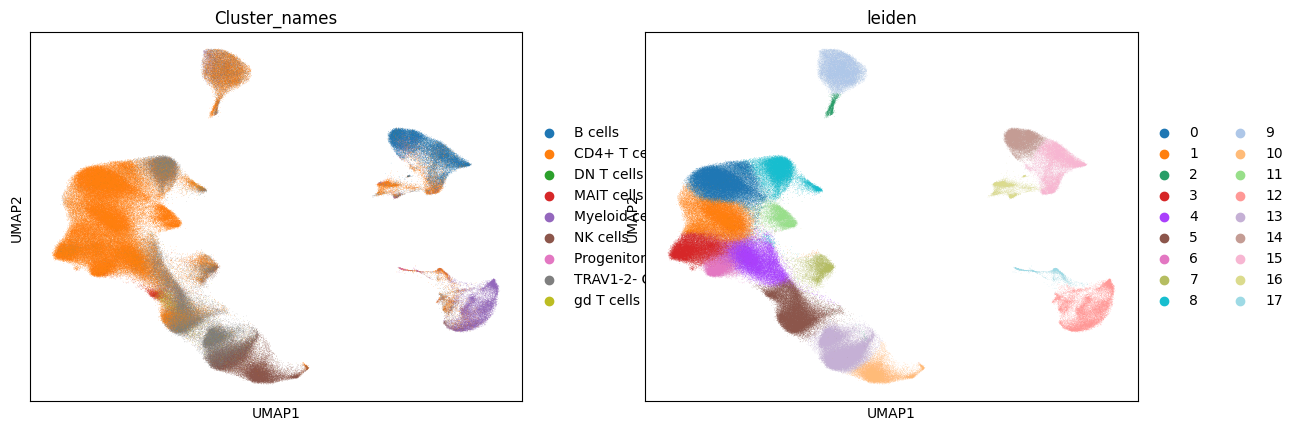

In [10]:
sc.pl.umap(rna_ctl, color=['Cluster_names','leiden'])

In [22]:
# define the number of the major cell linear clusters
m_ctl = {'12','17'}
b_ctl = {'14','15','16'}
c_ctl = {'0','1','3','4','5','6','7','8','10','11','13'}
rb_ctl = {'2','9'}

In [23]:
ctl_clusts = {}

for clust in m_ctl:
    ctl_clusts[clust] = 'Myeloid'

for clust in b_ctl:
    ctl_clusts[clust] = 'B'

for clust in c_ctl:
    ctl_clusts[clust] = 'C/NK'

for clust in rb_ctl:
    ctl_clusts[clust] = 'Dying'

In [24]:
rna_ctl.obs['lineage'] = rna_ctl.obs['leiden'].apply(lambda x: ctl_clusts[x])

... storing 'lineage' as categorical


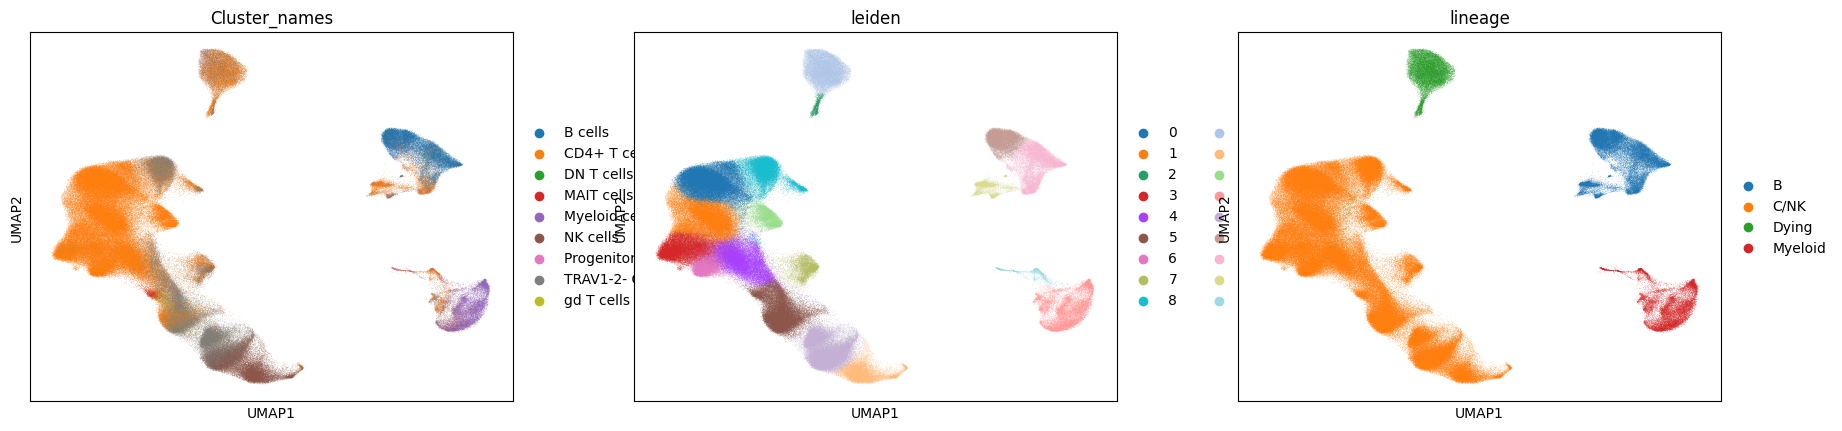

In [25]:
sc.pl.umap(rna_ctl, color=['Cluster_names','leiden','lineage'])

In [26]:
rna_ctl.obs['lineage_match'] = pd.Categorical(((rna_ctl.obs['lineage']=="Myeloid") & (rna_ctl.obs['Cluster_names']=="Myeloid cells")) |
                                            ((rna_ctl.obs['lineage']=="B") & (rna_ctl.obs['Cluster_names']=="B cells")) |
                                            ((rna_ctl.obs['lineage']=="C/NK") & (rna_ctl.obs['Cluster_names'] \
                                                                               .apply(lambda x: x in {"CD4+ T cells", "DN T cells",
                                                                                                      "MAIT cells", "NK cells",
                                                                                                      "TRAV1-2- CD8+ T cells", "gd T cells"}))) |
                                            ((rna_ctl.obs['lineage']=="Myeloid") & (rna_ctl.obs['Cluster_names']=="Progenitor cells")))

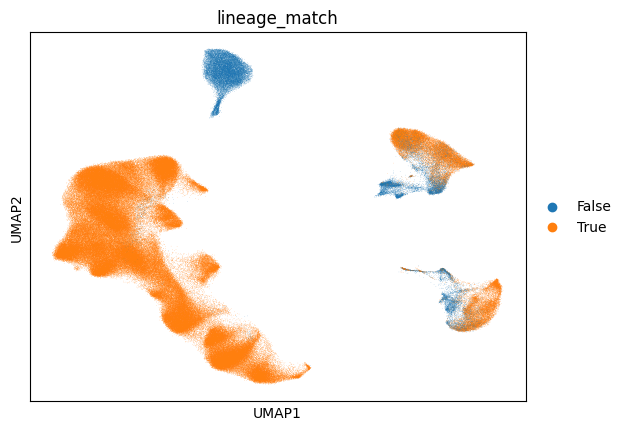

In [27]:
sc.pl.umap(rna_ctl, color=['lineage_match'])

... storing 'FCluster_names' as categorical
... storing 'Cluster_names' as categorical
... storing 'SCluster_names' as categorical


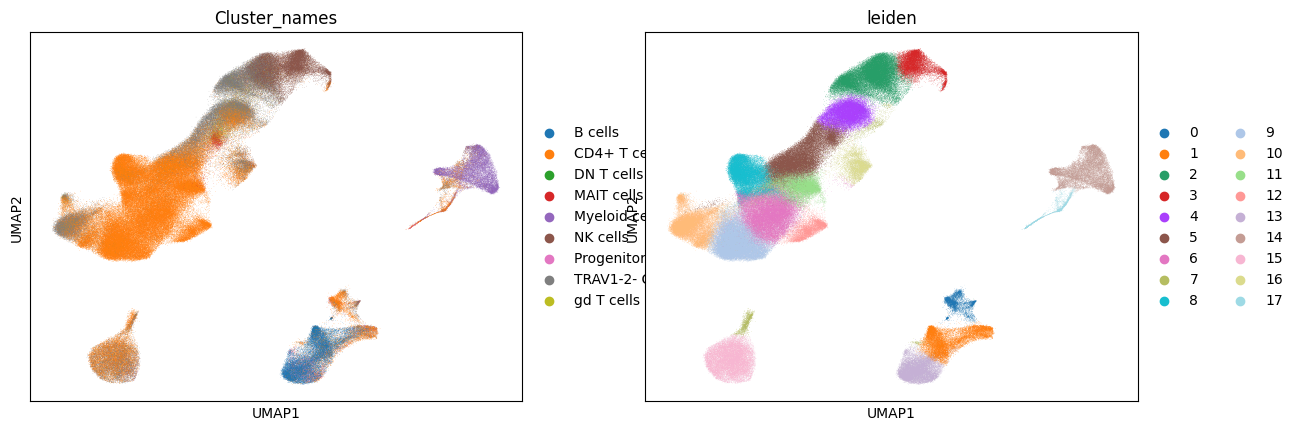

In [28]:
sc.pl.umap(rna_lps, color=['Cluster_names','leiden'])

In [29]:
# clusters 8 and 22 have very high ribosomal gene counts (>20% average) so I'll remove
# define the number of the major cell linear clusters
m_lps = {'14','17'}
b_lps = {'0','1','13'}
c_lps = {'2','3','4','5','6','8','9','10','11','12','16'}
rb_lps = {'15','7'}

In [30]:
lps_clusts = {}

for clust in m_lps:
    lps_clusts[clust] = 'Myeloid'

for clust in b_lps:
    lps_clusts[clust] = 'B'

for clust in c_lps:
    lps_clusts[clust] = 'C/NK'

for clust in rb_lps:
    lps_clusts[clust] = 'Dying'

In [31]:
rna_lps.obs['lineage'] = rna_lps.obs['leiden'].apply(lambda x: lps_clusts[x])

... storing 'lineage' as categorical


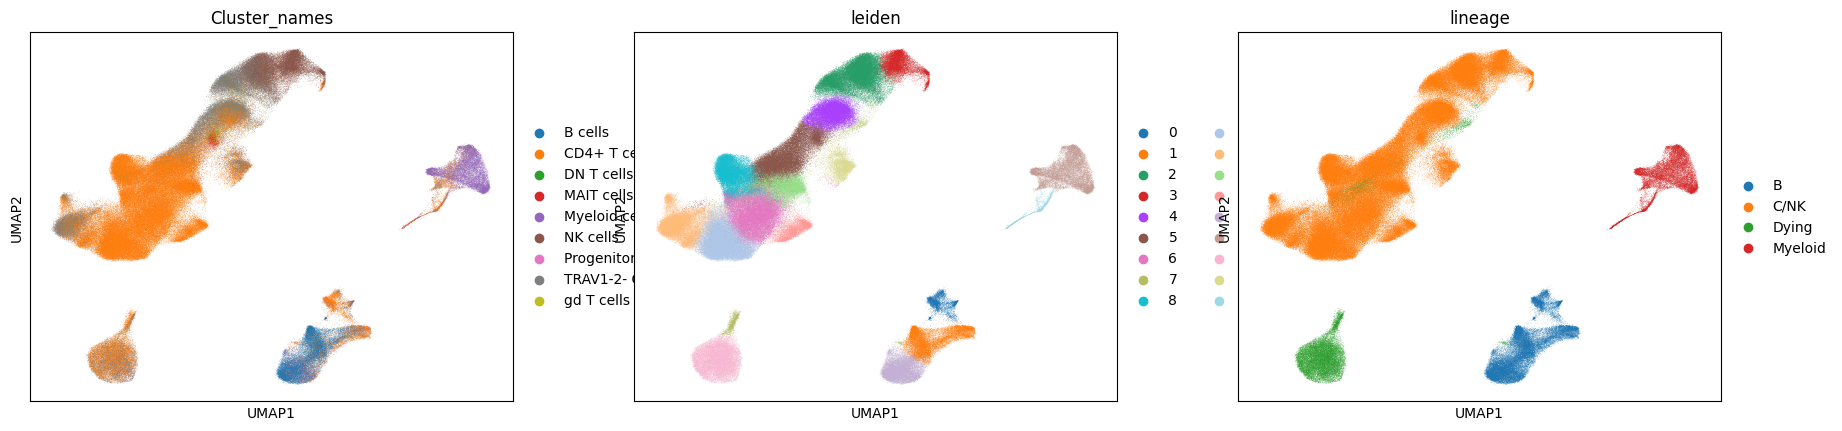

In [32]:
sc.pl.umap(rna_lps, color=['Cluster_names','leiden','lineage'])

In [33]:
rna_lps.obs['lineage_match'] = pd.Categorical(((rna_lps.obs['lineage']=="Myeloid") & (rna_lps.obs['Cluster_names']=="Myeloid cells")) |
                                            ((rna_lps.obs['lineage']=="B") & (rna_lps.obs['Cluster_names']=="B cells")) |
                                            ((rna_lps.obs['lineage']=="C/NK") & (rna_lps.obs['Cluster_names'] \
                                                                               .apply(lambda x: x in {"CD4+ T cells", "DN T cells",
                                                                                                      "MAIT cells", "NK cells",
                                                                                                      "TRAV1-2- CD8+ T cells", "gd T cells"}))) |
                                            ((rna_lps.obs['lineage']=="Myeloid") & (rna_lps.obs['Cluster_names']=="Progenitor cells")))

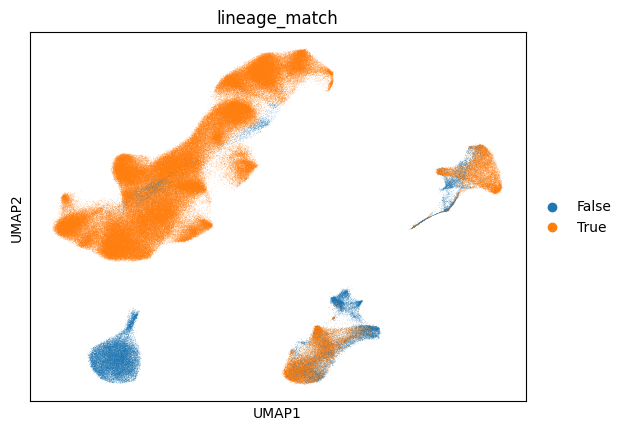

In [35]:
sc.pl.umap(rna_lps, color=['lineage_match'])

In [36]:
rna_ctl_clean = rna_ctl[rna_ctl.obs['lineage_match']==True]

In [37]:
rna_lps_clean = rna_lps[rna_lps.obs['lineage_match']==True]

In [38]:
rna_ctl_clean.write("write/MR_ctl_raw.umap.clean.h5ad")
rna_lps_clean.write("write/MR_lps_raw.umap.clean.h5ad")

### Assign cell types to ATAC-seq

In [6]:
rna_ctl = sc.read_h5ad("write/MR_ctl_raw.umap.clean.h5ad")
rna_lps = sc.read_h5ad("write/MR_lps_raw.umap.clean.h5ad")

In [5]:
atac = snap.read_dataset("MA_all.h5ads")

In [ ]:
atac.subset(obs_indices = list(rna_ctl.obs_names) + list(rna_lps.obs_names), out="write/anndatas")

In [21]:
atac.close()

In [4]:
atac = snap.read_dataset("write/anndatas/_dataset.h5ads")

In [7]:
atac

AnnDataSet object with n_obs x n_vars = 569956 x 6062095 backed at 'write/anndatas/_dataset.h5ads'
contains 52 AnnData objects with keys: 'MRA13', 'MRA14', 'MRA15', 'MRA16', 'MRA17', 'MRA18', 'MRA19', 'MRA20', 'MRA21', 'MRA22', 'MRA23', 'MRA24', 'MRA25', 'MRA26', 'MRA27', 'MRA28', 'MRA29', 'MRA30', 'MRA31', 'MRA32', 'MRA33', 'MRA34', 'MRA35', 'MRA36', 'MRA37', 'MRA38', 'MRA39', 'MRA40', 'MRA41', 'MRA42', 'MRA43', 'MRA44', 'MRA45', 'MRA46', 'MRA47', 'MRA48', 'MRA49', 'MRA50', 'MRA51', 'MRA52', 'MRA53', 'MRA54', 'MRA55', 'MRA56', 'MRA57', 'MRA58', 'MRA59', 'MRA60', 'MRA61', 'MRA62', 'MRA63', 'MRA64'
    obs: 'sample', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity'
    uns: 'AnnDataSet', 'reference_sequences'

In [8]:
rna = sc.concat([rna_ctl, rna_lps])

In [9]:
# rename cell types to be valid for export
ctype_map = {"B cells": "B",
             "CD4+ T cells" : "CD4-T",
             "DN T cells" : "DNT",            
             "MAIT cells" : "MAIT",
             "Myeloid cells" : "M",
             "NK cells" : "NK",
             "Progenitor cells" : "Progenitor",
             "TRAV1-2- CD8+ T cells" : "CD8-T",
             "gd T cells" : "gdT"}

In [10]:
atac.obs['FCluster_names'] = rna.obs.loc[atac.obs_names, 'FCluster_names']
atac.obs['Cluster_names'] = rna.obs.loc[atac.obs_names, 'Cluster_names']
atac.obs['SCluster_names'] = rna.obs.loc[atac.obs_names, 'SCluster_names']

In [11]:
atac.obs['ct1'] = pd.Series(atac.obs['Cluster_names']).apply(lambda x: ctype_map[x])

/tmp/ipykernel_123825/3136960837.py:1: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  atac.obs['ct1'] = pd.Series(atac.obs['Cluster_names']).apply(lambda x: ctype_map[x])


In [12]:
atac

AnnDataSet object with n_obs x n_vars = 569956 x 6062095 backed at 'write/anndatas/_dataset.h5ads'
contains 52 AnnData objects with keys: 'MRA13', 'MRA14', 'MRA15', 'MRA16', 'MRA17', 'MRA18', 'MRA19', 'MRA20', 'MRA21', 'MRA22', 'MRA23', 'MRA24', 'MRA25', 'MRA26', 'MRA27', 'MRA28', 'MRA29', 'MRA30', 'MRA31', 'MRA32', 'MRA33', 'MRA34', 'MRA35', 'MRA36', 'MRA37', 'MRA38', 'MRA39', 'MRA40', 'MRA41', 'MRA42', 'MRA43', 'MRA44', 'MRA45', 'MRA46', 'MRA47', 'MRA48', 'MRA49', 'MRA50', 'MRA51', 'MRA52', 'MRA53', 'MRA54', 'MRA55', 'MRA56', 'MRA57', 'MRA58', 'MRA59', 'MRA60', 'MRA61', 'MRA62', 'MRA63', 'MRA64'
    obs: 'sample', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'ct1'
    uns: 'AnnDataSet', 'reference_sequences'

In [13]:
atac.close()

### Export fragments

In [4]:
atac = snap.read_dataset("write/anndatas/_dataset.h5ads")

In [5]:
from pathlib import Path

In [ ]:
snap.ex.export_fragments(
    atac,
    groupby="ct1",
    out_dir=Path("write/fragments_output/ctype_by_cond_by_pop"),
    prefix="fragments",
    suffix=".bed"
)

Using `snap.ex.export_fragments` to export fragments split by cell type, condition, and population leads to crashing due to the fact that a true dataframe implementation hasn't been implemented for AnnDataSets, and the workaround of saving the `.obsm['fragment_paired']` information from the .adatas to the AnnDataSet also leads to crashing. Macs3 allows a user to specify a subset of barcodes to use, which can allow me to export the barcodes I care about. In order to do this, I can use the fragments I've exported previously separated by celltype; an advantage of this over using the original fragment files is the original files do not have a library identifier appended to their barcodes, leading to possible collision.

Certain cell types, namely DNT and Progenitor cells, do not have sufficient reads to split for peak calling, which I should take into account during analysis.

In [19]:
ctype="B"
cond="CTL"
pop="Tikari"

out_file = "write/split_barcodes/fragments_{}_{}_{}.tsv.gz".format(ctype,cond,pop)

pd.Series(atac.obs_names)[list((atac.obs['ct1']==ctype) & 
                                           (atac.obs['COND']==cond) & 
                                           (atac.obs['Ethnicity']==pop))].to_csv(out_file, header=False, index=False)

/tmp/ipykernel_293087/3715694743.py:7: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  pd.Series(atac.obs_names)[list((atac.obs['ct1']==ctype) &
/tmp/ipykernel_293087/3715694743.py:8: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  (atac.obs['COND']==cond) &
/tmp/ipykernel_293087/3715694743.py:9: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  (atac.obs['Ethnicity']==pop))].to_csv(out_file, header=False, index=False)


In [ ]:
ctypes = ['B', 'CD4-T', 'CD8-T', 'DNT', 'M', 'MAIT', 'NK', 'Progenitor', 'gdT']
conds = ['CTL','LPS']
pops = ['Tikari','Fulani']

for ctype in ctypes:
    for cond in conds:
        for pop in pops:

            out_file = "write/split_barcodes/fragments_{}_{}_{}.tsv.gz".format(ctype,cond,pop)
            
            pd.Series(atac.obs_names)[list((atac.obs['ct1']==ctype) & 
                                           (atac.obs['COND']==cond) & 
                                           (atac.obs['Ethnicity']==pop))].to_csv(out_file, header=False, index=False)

In [17]:
np.unique(atac.obs['ct1'])

/tmp/ipykernel_293087/1679323326.py:1: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  np.unique(atac.obs['ct1'])


array(['B', 'CD4-T', 'CD8-T', 'DNT', 'M', 'MAIT', 'NK', 'Progenitor',
       'gdT'], dtype='<U10')

<Axes: ylabel='Frequency'>

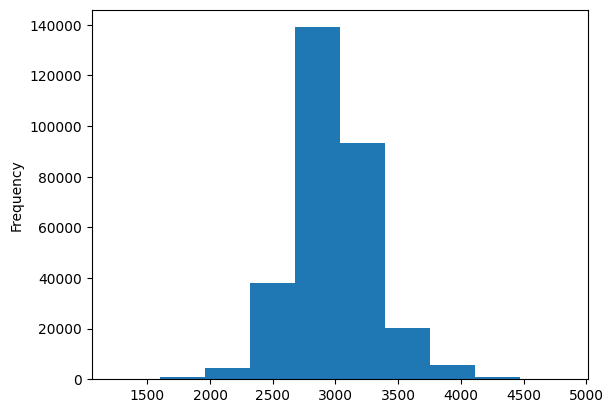

In [27]:
rna_ctl.obs['total_counts'].plot.hist()

In [ ]:
atac.close()

### Export fragment counts

In [29]:
atacs = snap.read_dataset("write/anndatas/_dataset.h5ads")

In [42]:
info_df = pd.DataFrame({'CTYPE': atacs.obs['ct1'],
                        'COND': atacs.obs['COND'],
                        'POP': atacs.obs['Ethnicity'],
                        'n_fragment': 0}, index=atacs.obs_names)

/tmp/ipykernel_123825/1506334364.py:1: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  info_df = pd.DataFrame({'CTYPE': atacs.obs['ct1'],
/tmp/ipykernel_123825/1506334364.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  'COND': atacs.obs['COND'],
/tmp/ipykernel_123825/1506334364.py:3: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  'POP': atacs.obs['Ethnicity'],


In [45]:
atacs.close()

In [47]:
i=13

In [ ]:
libs = range(13,65)
for i in libs:
    
    atac = snap.read("write/anndatas/anndatas/MRA{}.h5ad".format(i))
    info_df.loc[["MRA{}:".format(i) + x for x in atac.obs_names],'n_fragment'] = list(atac.obs['n_fragment'])
    atac.close()

In [94]:
fragment_counts = info_df.groupby(['CTYPE','COND','POP']).sum()

In [66]:
fragment_counts.reset_index().to_csv("misc/fragment_counts.split.txt", sep="\t", index=False)

### Filter summits

In [4]:
fragment_counts = pd.read_csv("misc/fragment_counts.split.txt", sep="\t")

In [10]:
ctypes = ['B', 'CD4-T', 'CD8-T', 'M', 'NK', 'Progenitor', 'gdT']
conds = ['CTL','LPS']
pops = ['Tikari','Fulani']

In [ ]:
for ctype in ctypes:
    for cond in conds:
        for pop in pops:

            nfrag = int(fragment_counts[(fragment_counts['CTYPE']==ctype) &
                        (fragment_counts['COND']==cond) &
                        (fragment_counts['POP']==pop)]['n_fragment'])
            peak_in = "write/peaks/split/peaks_{}_{}_{}_summits.bed".format(ctype,cond,pop)
            peak_out = "write/peaks/split/peaks_{}_{}_{}_summits.500bp.filt.bed".format(ctype,cond,pop)
            peaks = pd.read_csv(peak_in, sep="\t",
                                names=["chr","start","end","name","score"])

            peaks['start'] = peaks['start'] - 249
            peaks['end'] = peaks['end'] + 250
            peaks['score_norm'] = peaks['score']/nfrag*100000000

            peaks[peaks['score_norm'] > 1].to_csv(peak_out, sep="\t", index=False, header=None)


Get best peak for each merged peak and replace for each narrowpeak file

In [6]:
peaks = pd.read_csv("write/peaks/split/peaks_ALL_summits.500bp.filt.merge.isect_all.bed", sep="\t",
                    names=["chr_merge","start_merge","end_merge","merge_id","idx","chr","start","stop","peak_id","qval","score"])

In [7]:
peaks['score_max'] = peaks.groupby(['merge_id'])['score'].transform(max)

/tmp/ipykernel_222778/1218458094.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  peaks['score_max'] = peaks.groupby(['merge_id'])['score'].transform(max)


In [8]:
peaks_max = peaks[peaks['score']==peaks['score_max']][['merge_id','chr','start','stop','peak_id','score']]

In [9]:
peaks_replace = peaks_max.rename(columns={'peak_id': 'peak_max'})[['chr','start','stop','merge_id','peak_max','score']] \
    .merge(peaks[['merge_id','peak_id']])

In [17]:
peaks_max[['chr','start','stop','merge_id','peak_id','score']] \
    .to_csv("write/peaks/split/peaks_ALL_summits.500bp.filt.merge.max.bed", sep="\t", index=False, header=None)

In [21]:
peaks_replace[['prefix','foo']] = peaks_replace['peak_id'].str.split('_peak', n=1, expand=True)

In [24]:
peaks_replace.head()

chr  start   stop         merge_id                     peak_max  \
0  chr1   9868  10368  chr1:9865-10607  peaks_gdT_CTL_Tikari_peak_1   
1  chr1   9868  10368  chr1:9865-10607  peaks_gdT_CTL_Tikari_peak_1   
2  chr1   9868  10368  chr1:9865-10607  peaks_gdT_CTL_Tikari_peak_1   
3  chr1   9868  10368  chr1:9865-10607  peaks_gdT_CTL_Tikari_peak_1   
4  chr1   9868  10368  chr1:9865-10607  peaks_gdT_CTL_Tikari_peak_1   

        score                        peak_id                  prefix foo  
0  641.886955      peaks_B_CTL_Fulani_peak_1      peaks_B_CTL_Fulani  _1  
1  641.886955      peaks_B_CTL_Tikari_peak_1      peaks_B_CTL_Tikari  _1  
2  641.886955      peaks_B_LPS_Fulani_peak_1      peaks_B_LPS_Fulani  _1  
3  641.886955      peaks_B_LPS_Tikari_peak_1      peaks_B_LPS_Tikari  _1  
4  641.886955  peaks_CD4-T_CTL_Fulani_peak_1  peaks_CD4-T_CTL_Fulani  _1

In [26]:
prefixes = np.unique(peaks_replace['prefix'])
for prefix in prefixes:
    out_file = "write/peaks/split/{}_summits.500bp.replace.bed".format(prefix)
    peaks_replace[peaks_replace['prefix']==prefix].drop(['prefix','foo'], axis=1).to_csv(out_file, sep="\t", index=False)

In [27]:
pref_cols = ["chr","start","stop","merge_id","peak_max","score","peak_id"]

### Create peak matrices for each library

#### Test

Going to test on one library before I go primetime. The goal is to create a peak matrix for each library (cell x peak) and then integrate them. At each step I'll summarize by individual, cell type, and condition and integrate them at a later date.

In [51]:
rna_ctl = sc.read_h5ad("write/MR_ctl_raw.umap.clean.h5ad")
rna_lps = sc.read_h5ad("write/MR_lps_raw.umap.clean.h5ad")

In [ ]:
rna = sc.concat([rna_ctl, rna_lps])

In [64]:
ctype_map = {"B cells": "B",
             "CD4+ T cells" : "CD4-T",
             "DN T cells" : "DNT",            
             "MAIT cells" : "MAIT",
             "Myeloid cells" : "M",
             "NK cells" : "NK",
             "Progenitor cells" : "Progenitor",
             "TRAV1-2- CD8+ T cells" : "CD8-T",
             "gd T cells" : "gdT"}

In [65]:
rna.obs['cytopus_names'] = rna.obs['Cluster_names'].apply(lambda x: ctype_map[x])

In [4]:
atac = snap.read("write/anndatas/anndatas/MRA13.h5ad")

In [18]:
peak_mat = snap.pp.make_peak_matrix(atac, peak_file = "write/peaks/split/peaks_ALL_summits.500bp.filt.merge.max.bed")

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [70]:
lib=13

In [66]:
peak_mat.obs[['TID','FID','BATCH','COND','SEX','AGE','Ethnicity','FCluster_names','Cluster_names','SCluster_names','cytopus_names']] = \
    rna.obs.loc[peak_mat.obs_names][['TID','FID','BATCH','COND','SEX','AGE','Ethnicity','FCluster_names','Cluster_names','SCluster_names','cytopus_names']]

In [67]:
peak_sum = grouped_obs_sum(peak_mat, group_key = ['FID','cytopus_names','COND'])

/tmp/ipykernel_222778/2077685860.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)


In [69]:
atac.close()

#### Analyze

In [3]:
libs = range(13,65)

In [4]:
peak_list = []
for lib in libs:

    peaks = pd.read_csv("write/peaks/peak_mats/MRA{}.peak_mat.csv".format(lib), index_col=0)
    peak_list.append(peaks)

In [5]:
peak_cols = list(np.unique([i for x in peak_list for i in x.columns]))

In [51]:
peak_df = pd.DataFrame(0, index=peak_list[0].index, columns=peak_cols)

In [58]:
peak_df[peaks.columns] = peak_df[peaks.columns] + peaks

In [62]:
for peaks in peak_list:
    peak_df[peaks.columns] = peak_df[peaks.columns] + peaks

In [66]:
peak_df.to_csv("write/peaks/peak_mats/Merged.peak_mat.csv")

In [54]:
peak_df.loc[peaks.columns]

KeyError: "None of [Index(['('D0746', 'B', 'LPS')', '('D0746', 'CD4-T', 'LPS')',\n       '('D0746', 'CD8-T', 'LPS')', '('D0746', 'DNT', 'LPS')',\n       '('D0746', 'M', 'LPS')', '('D0746', 'MAIT', 'LPS')',\n       '('D0746', 'NK', 'LPS')', '('D0746', 'Progenitor', 'LPS')',\n       '('D0746', 'gdT', 'LPS')', '('D0786', 'B', 'LPS')',\n       '('D0786', 'CD4-T', 'LPS')', '('D0786', 'CD8-T', 'LPS')',\n       '('D0786', 'M', 'LPS')', '('D0786', 'MAIT', 'LPS')',\n       '('D0786', 'NK', 'LPS')', '('D0786', 'gdT', 'LPS')',\n       '('D1182', 'B', 'LPS')', '('D1182', 'CD4-T', 'LPS')',\n       '('D1182', 'CD8-T', 'LPS')', '('D1182', 'M', 'LPS')',\n       '('D1182', 'MAIT', 'LPS')', '('D1182', 'NK', 'LPS')',\n       '('D1182', 'Progenitor', 'LPS')', '('D1182', 'gdT', 'LPS')',\n       '('D1321', 'B', 'LPS')', '('D1321', 'CD4-T', 'LPS')',\n       '('D1321', 'CD8-T', 'LPS')', '('D1321', 'M', 'LPS')',\n       '('D1321', 'MAIT', 'LPS')', '('D1321', 'NK', 'LPS')',\n       '('D1321', 'Progenitor', 'LPS')', '('D1321', 'gdT', 'LPS')'],\n      dtype='object')] are in the [index]"

In [18]:
peaks_sum = pd.read_csv("write/peaks/peak_mats/MRA13.peak_mat.csv", index_col=0)

In [19]:
peaks = pd.read_csv("write/peaks/peak_mats/MRA14.peak_mat.csv", index_col=0)

In [20]:
peaks_sum = peaks_sum + peaks

### Misc

In [22]:
sc.tl.rank_genes_groups(rna_ctl, groupby="leiden", method="wilcoxon")

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [14]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

In [ ]:
#drop_genes = ['CCR7', 'CD247', 'CD4', 'CLEC10A', 'COTL1', 'FCER1A', 'FCN1', 'GYPA', 'HBM', 'HSP90B1', 'IL4R', 'IL7R', 'MKI67', 'PRDM1', 'TCF7', 'TRBC2', 'XBP1']

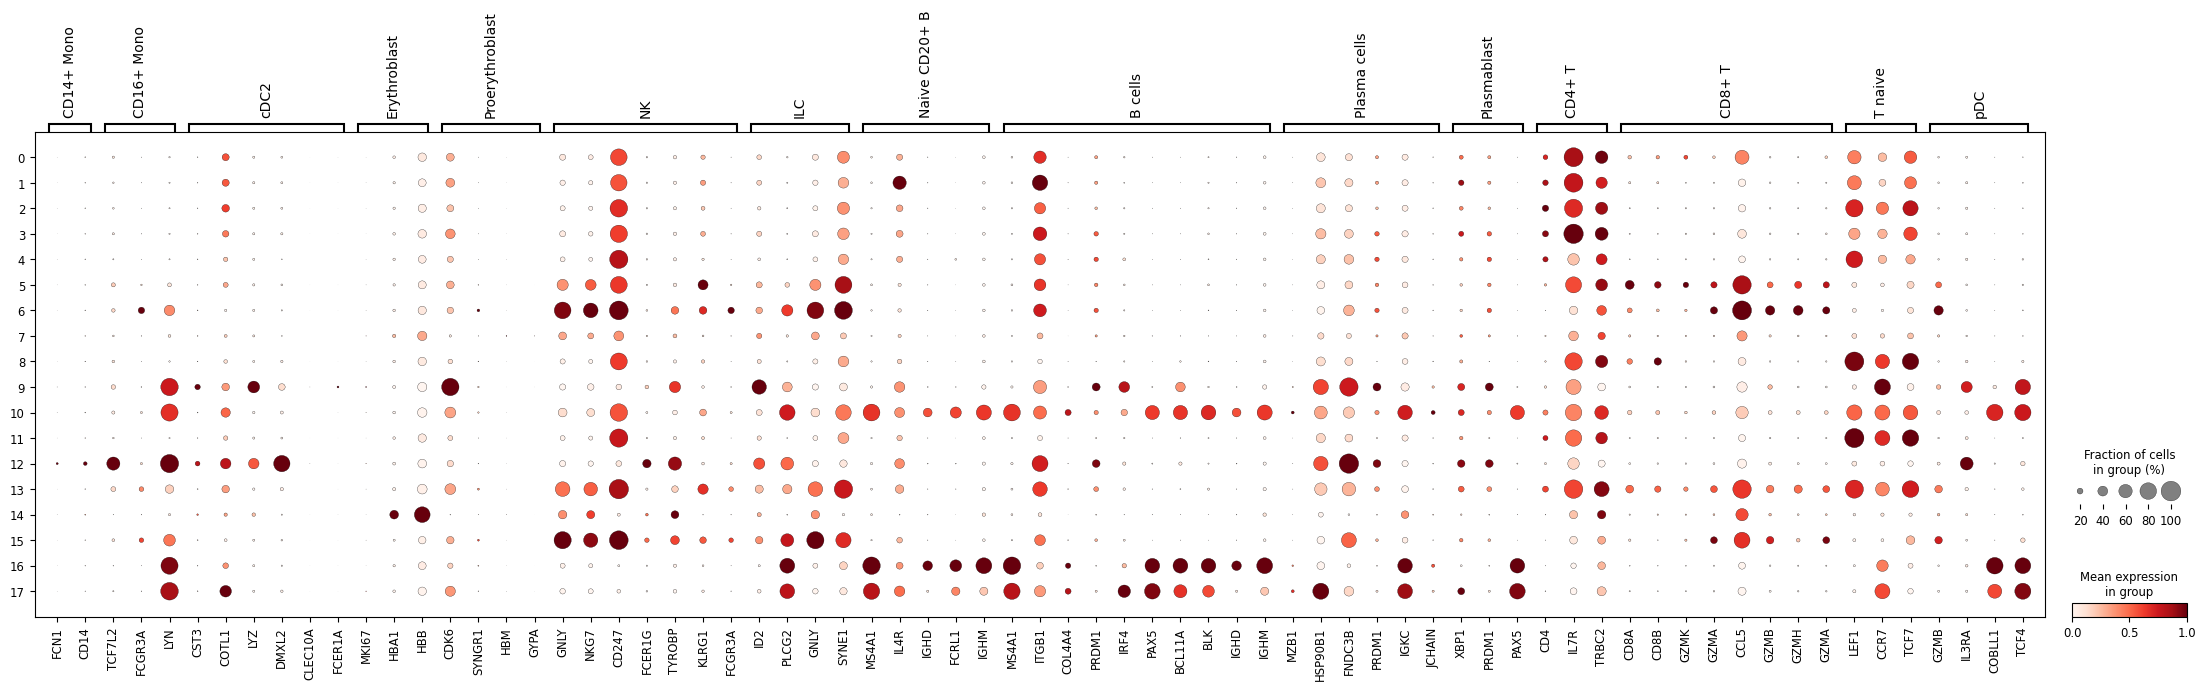

In [15]:
sc.pl.dotplot(rna_ctl, marker_genes, groupby="leiden", standard_scale="var")

In [37]:
# ribosomal genes
rna_ctl.var["ribo"] = rna_ctl.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
rna_ctl.var["hb"] = rna_ctl.var_names.str.contains("^HB[^(P)]")

In [39]:
sc.pp.calculate_qc_metrics(
    rna_ctl, qc_vars=["ribo", "hb"], inplace=True, log1p=True
)

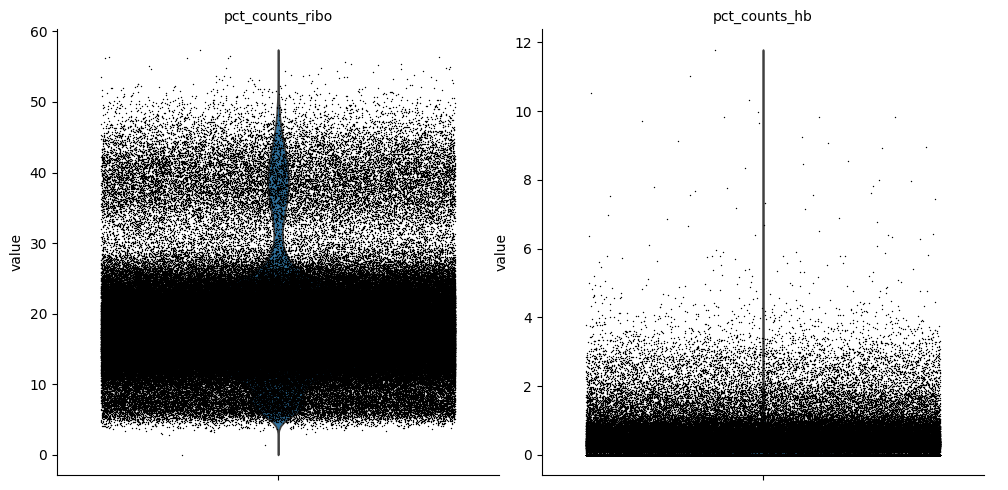

In [42]:
sc.pl.violin(
    rna_ctl,
    ["pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

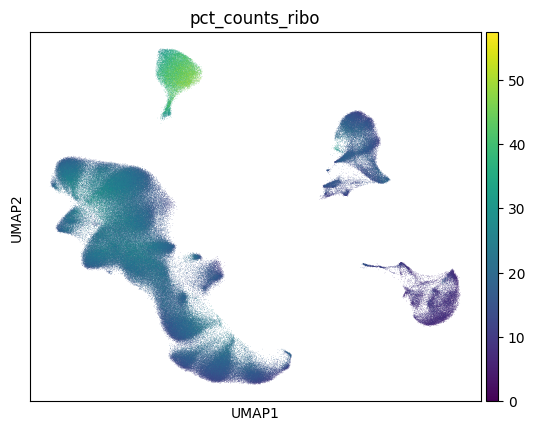

In [43]:
sc.pl.umap(rna_ctl, color=["pct_counts_ribo"])

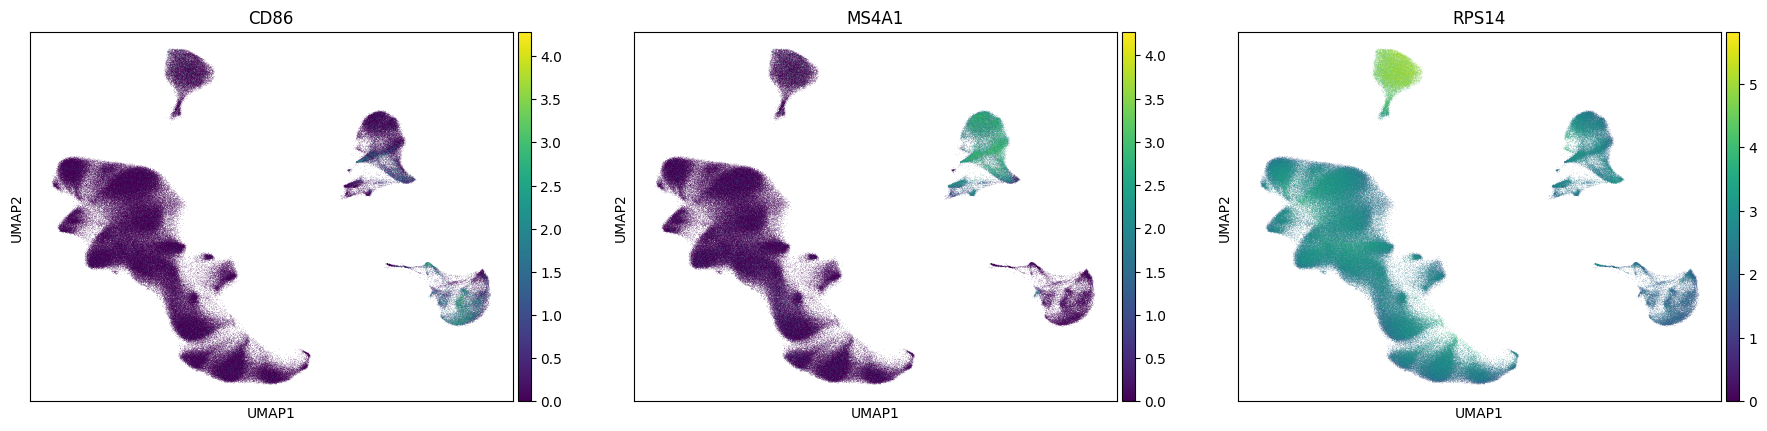

In [30]:
sc.pl.umap(rna_ctl, color=["CD86","MS4A1","RPS14"])

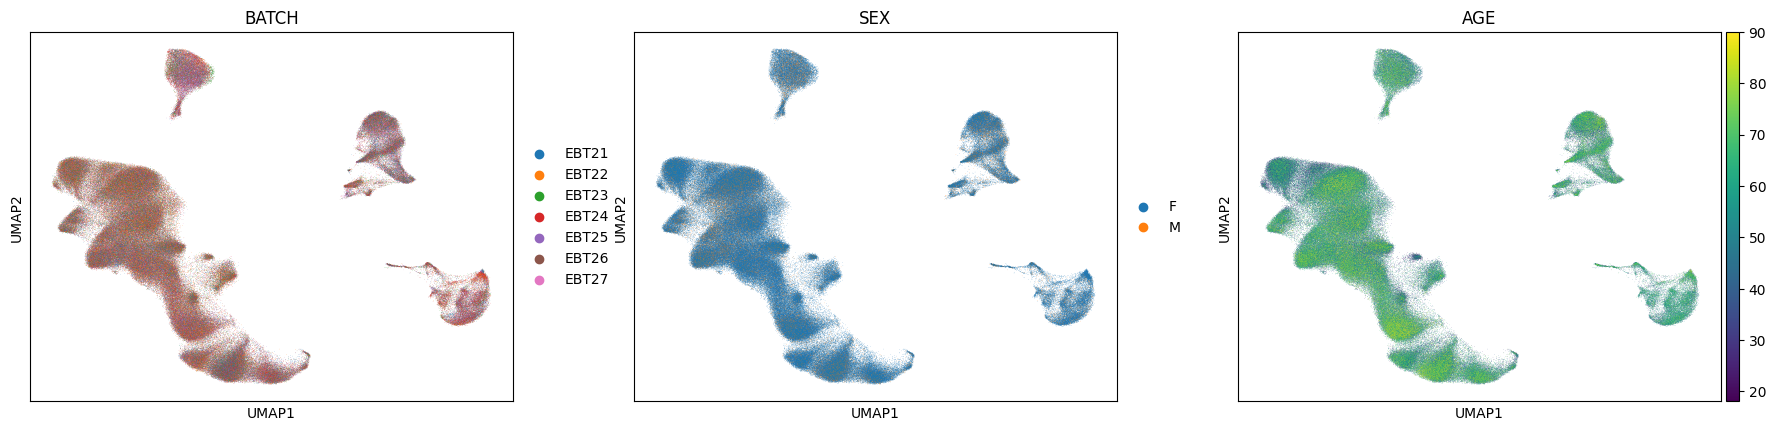

In [31]:
sc.pl.umap(rna_ctl, color=["BATCH","SEX","AGE"])

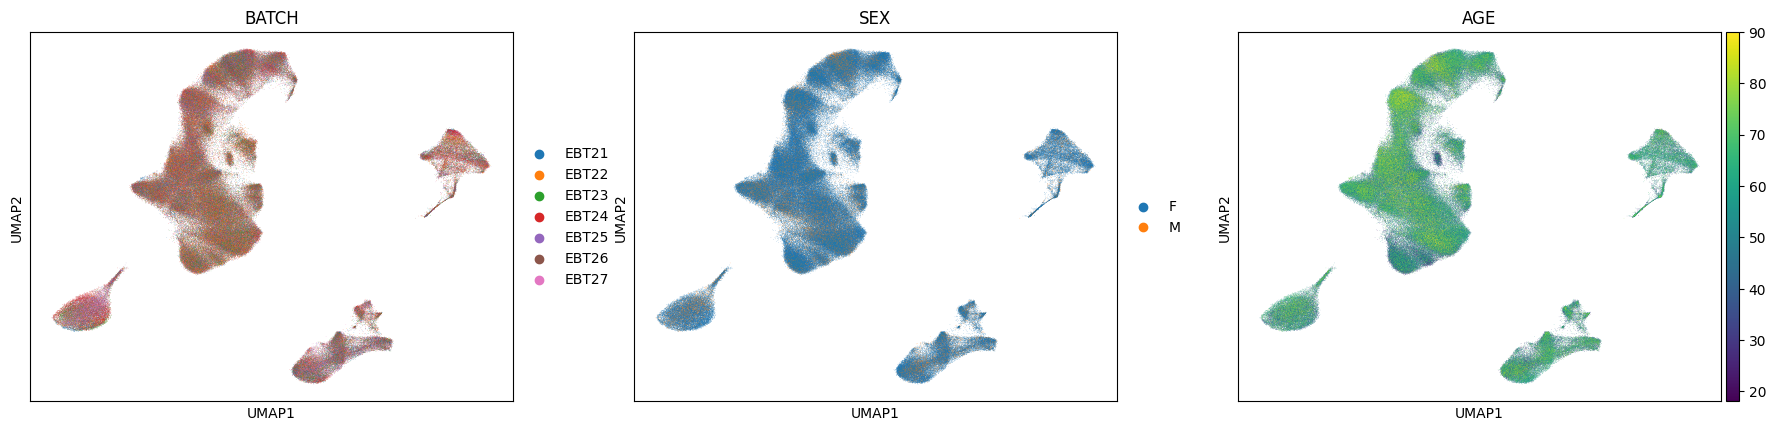

In [32]:
sc.pl.umap(rna_lps, color=["BATCH","SEX","AGE"])

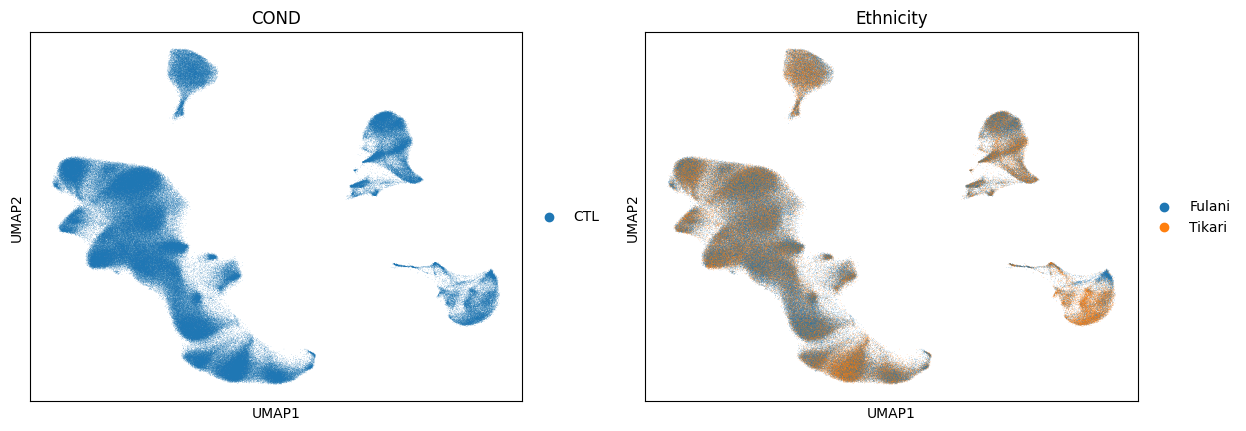

In [33]:
sc.pl.umap(rna_ctl, color=["COND","Ethnicity"])

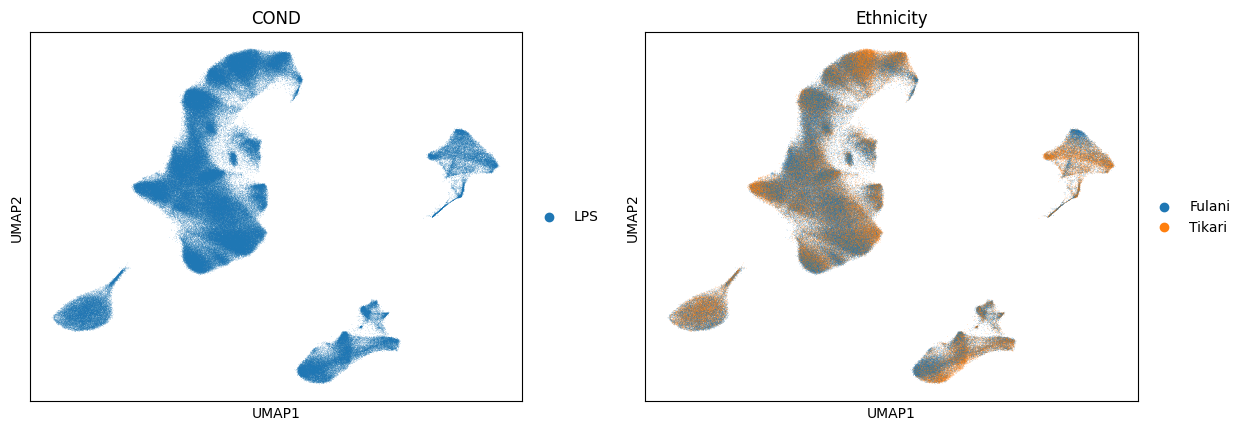

In [34]:
sc.pl.umap(rna_lps, color=["COND","Ethnicity"])

In [122]:
rna_umap.obs['coarse_ctype'] = "C_NK_Misc"

In [123]:
# set B cell label
rna_umap.obs.loc[(rna_umap.obsm['X_umap'][:,0] > 5) & (rna_umap.obsm['X_umap'][:,1] > 8), 'coarse_ctype'] = "B"

In [124]:
# set Myeloid cell label
rna_umap.obs.loc[(rna_umap.obsm['X_umap'][:,0] > 8) & (rna_umap.obsm['X_umap'][:,1] < 5), 'coarse_ctype'] = "M"

In [126]:
atac.obs['coarse_ctype'] = rna_umap.obs.loc[atac.obs_names,'coarse_ctype']

In [ ]:
# call peaks
snap.tl.macs3(atac, groupby='coarse_ctype')

2025-05-13 07:48:15 - INFO - Exporting fragments...
2025-05-13 11:49:33 - INFO - Calling peaks...
  0%|                                                                                                                                     | 0/3 [00:00<?, ?it/s]

In [ ]:
atac.obsm['X_joint'] = embedding
snap.tl.umap(atac, use_rep='X_joint')

In [130]:
i=13
lib_group = "M13_M20"

ambimux = pd.read_csv("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t", index_col=0)
singlets = ambimux[ambimux.best_type=="Singlet"]['best_singlet'].to_frame()

in_path = "/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_count/{}/MRA{}/outs/filtered_feature_bc_matrix".format(lib_group, i)
out_file = "write/MR{}.h5ad".format(i)

# rna = sc.read_10x_mtx(path=in_path)

In [99]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
rna.var["mt"] = rna.var_names.str.startswith("MT-")


In [100]:
sc.pp.calculate_qc_metrics(
    rna, qc_vars=["mt"], inplace=True, log1p=True
)

In [101]:
rna = rna[((rna.obs.pct_counts_mt < 10) &
           (rna.obs.total_counts > 500) &
           (rna.obs.n_genes_by_counts > 250))]

In [131]:
bc_overlap = list(set(singlets.index).intersection(set(rna.obs_names)))

In [133]:
rna = rna[rna.obs_names.isin(set(bc_overlap))]

In [134]:
rna

View of AnnData object with n_obs × n_vars = 15671 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [135]:
rna.obs['donor_id'] = ambimux.loc[rna.obs_names, 'best_singlet']

/tmp/ipykernel_215990/1380625324.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs['donor_id'] = ambimux.loc[rna.obs_names, 'best_singlet']


In [88]:
atac.subset(obs_indices=bc_overlap)

In [92]:
rna.write("write/MR{}.h5ad".format(i))

... storing 'donor_id' as categorical
... storing 'feature_types' as categorical


In [118]:
foo = sc.read_h5ad("write/MR13.h5ad")

In [120]:
i=13

ambimux = pd.read_csv("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
singlets = ambimux[ambimux.best_type=="Singlet"]['best_singlet'].to_frame()

In [121]:
in_path = "/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_count/{}/MRA{}/outs/filtered_feature_bc_matrix".format(lib_group, i)

In [122]:
rna = sc.read_10x_mtx(path=in_path) # read in rna data                                                                                                  

In [123]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse                                                                                                 
rna.var["mt"] = rna.var_names.str.startswith("MT-")

In [124]:
sc.pp.calculate_qc_metrics(
    rna, qc_vars=["mt"], inplace=True, log1p=True
)

In [125]:
rna = rna[((rna.obs.pct_counts_mt < 10) &
           (rna.obs.total_counts > 500) &
           (rna.obs.n_genes_by_counts > 250))]

In [126]:
bc_overlap = list(set(singlets.index).intersection(set(rna.obs_names)))

In [129]:
ambimux[ambimux.best_type=="Singlet"]

Barcode  n_rna_molecules  n_atac_molecules  n_features  \
15     CTTTGGGAGGAACGGT-1             4011             12458        1926   
22     CGACTAAGTTGTTGCT-1             4872              4969        2350   
28     CAATCTAAGATACTTG-1             4641               227        2123   
30     CTTCACTCACTTAACG-1             3518              9114        1717   
31     GTAGCGCTCTACCTAT-1             4563              2103        2135   
...                   ...              ...               ...         ...   
84545  GCTAGTGTCCGGTATG-1             2799             17074        1556   
84546  AGTTGCAGTTAACACG-1             3593             14483        1788   
84551  ACTTGTCGTTGTGACA-1             3236             19574        1772   
84555  GTGTGAGCAAGGGTTG-1             4062             16222        1966   
84560  CACCAACCAGGCGATA-1             5134             17767        2229   

       n_peaks  n_rna_info  n_atac_info  n_rna_variants  n_atac_variants  \
15        4326         820          920             893             1171   
22        1978        1039          381            1151              473   
28         101         997           11            1170               12   
30        3239         751          644             876              773   
31         850         872          137             981              168   
...        ...         ...          ...             ...              ...   
84545     5478         574         1243             648             1499   
84546     4823         799         1021             953             1264   
84551     5940         669         1370             765             1679   
84555     5190         834         1123             940             1382   
84560     5458        1142         1264            1218             1550   

       rna_pct_mt  ...  best_atac_ambient  atac_ambient_info  best_singlet  \
15        0.04961  ...           0.012747         174.227460     NWD252740   
22        0.04167  ...           0.390209          78.136052     NWD389867   
28        0.05236  ...           0.030075           3.079705     NWD359498   
30        0.04122  ...           0.049043         125.346060     NWD252740   
31        0.07539  ...           0.005236          27.155877     NWD359498   
...           ...  ...                ...                ...           ...   
84545     0.05859  ...           0.022068         229.291620     NWD372040   
84546     0.04370  ...           0.032698         189.618760     NWD252740   
84551     0.04450  ...           0.010637         254.268060     NWD372040   
84555     0.04801  ...           0.006106         223.865190     NWD389867   
84560     0.03116  ...           0.020604         237.240410     NWD372040   

              best_doublet            PP0  PP1            PP2        LLK0  \
15     NWD252740:NWD389867  1.996656e-203  1.0   8.593790e-89  -925.16234   
22     NWD359498:NWD389867   2.398201e-42  1.0   1.644716e-16  -704.00337   
28     NWD302076:NWD359498   2.394177e-97  1.0   3.666057e-42  -535.32634   
30     NWD252740:NWD617289  5.694033e-153  1.0   9.719925e-71  -752.36672   
31     NWD252740:NWD359498   8.117359e-97  1.0   9.564888e-40  -530.89841   
...                    ...            ...  ...            ...         ...   
84545  NWD252740:NWD372040  1.814678e-183  1.0   6.283149e-91  -909.95440   
84546  NWD252740:NWD372040  8.916156e-183  1.0   3.211360e-84  -946.13796   
84551  NWD359498:NWD372040  8.425116e-215  1.0  1.015433e-102 -1026.69210   
84555  NWD389867:NWD662575  2.895241e-228  1.0   1.910868e-92  -985.10079   
84560  NWD359498:NWD372040  2.090276e-230  1.0  3.877396e-106 -1236.80160   

            LLK1       LLK2  
15    -458.42904 -661.20807  
22    -608.16951 -644.51331  
28    -312.84863 -408.25809  
30    -401.81062 -563.01998  
31    -309.64166 -399.48696  
...          ...        ...  
84545 -489.17724 -696.87461  
84546 -526.95276 -719.20321  
84551 -533.76753 -768.61589  
84555 -461.17446 -672.36473  


In [ ]:
rna = rna[rna.obs_names.isin(set(bc_overlap))]

In [ ]:
rna.obs['donor_id'] = ambimux.loc[rna.obs_names, 'best_singlet']

In [48]:
ambimux[ambimux.best_type=="Singlet"]['best_singlet'].to_frame()

best_singlet
Barcode                        
CTTTGGGAGGAACGGT-1    NWD252740
CGACTAAGTTGTTGCT-1    NWD389867
CAATCTAAGATACTTG-1    NWD359498
CTTCACTCACTTAACG-1    NWD252740
GTAGCGCTCTACCTAT-1    NWD359498
...                         ...
GCTAGTGTCCGGTATG-1    NWD372040
AGTTGCAGTTAACACG-1    NWD252740
ACTTGTCGTTGTGACA-1    NWD372040
GTGTGAGCAAGGGTTG-1    NWD389867
CACCAACCAGGCGATA-1    NWD372040

[19121 rows x 1 columns]

<Axes: >

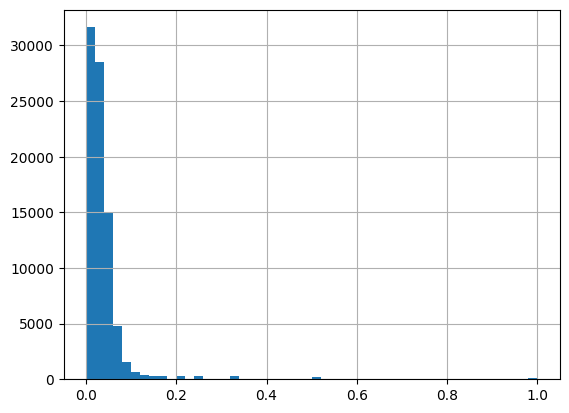

In [42]:
ambimux['rna_pct_mt'].hist(bins=50)

In [ ]:
adata.obs['index'] = [str(idx) + "_" + lib for idx in adata.obs.reset_index()['index']]

In [ ]:
rna = rna[rna.obs_names.isin(set(singlets))]

In [ ]:
rna = rna[((rna.obs.pct_counts_mt < 10) &
           (rna.obs.total_counts > 500) &
           (rna.obs.n_genes_by_counts > 250))]

... storing 'feature_types' as categorical


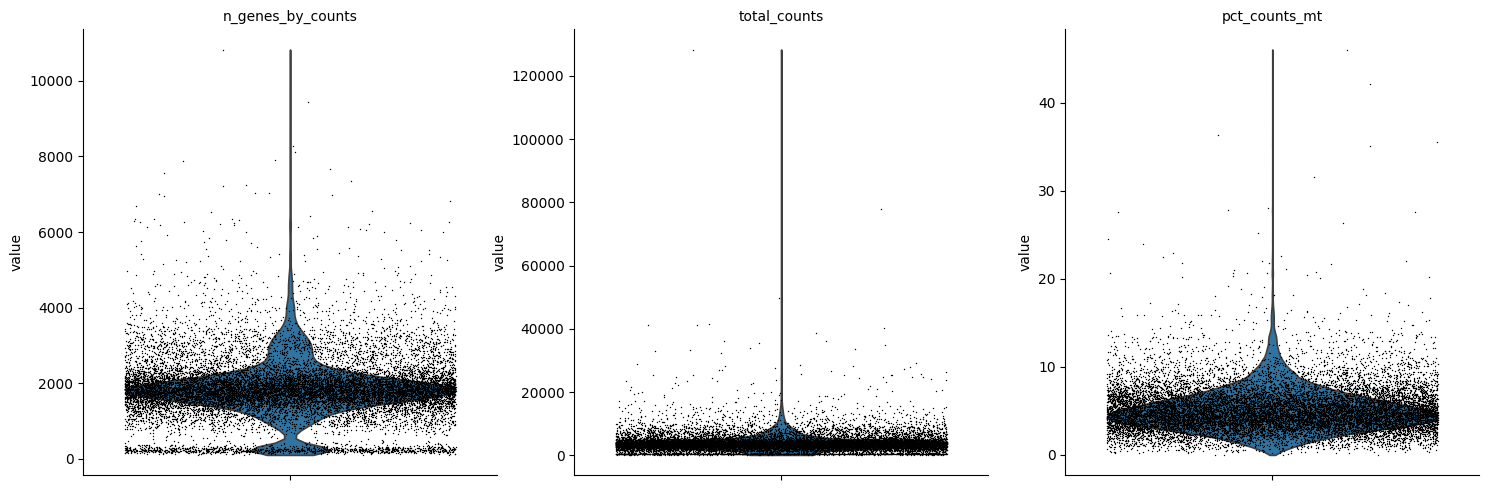

In [19]:
sc.pl.violin(
    rna,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [28]:
np.mean(rna.obs['pct_counts_mt'] > 10)

0.039307167434536654

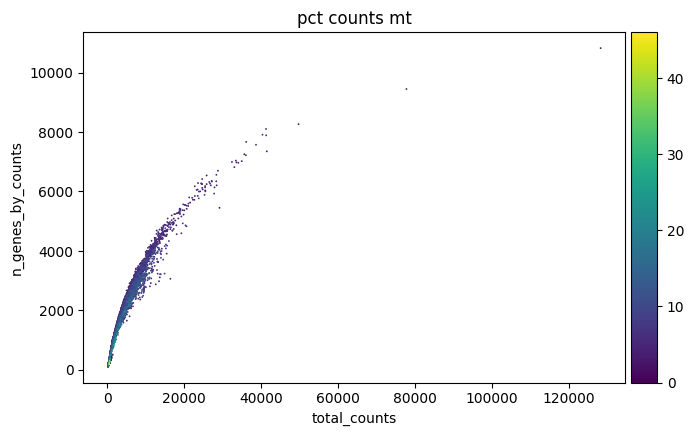

In [25]:
sc.pl.scatter(rna, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [16]:
len(set(atac.obs_names).intersection(set(rna.obs_names)))

17146

In [14]:
assert (rna.obs_names == atac.obs_names).all()

View of AnnData object with n_obs × n_vars = 17147 × 36601
    var: 'gene_ids', 'feature_types'

In [ ]:
rna_files = [("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_count/{}/MRA{}/outs/filtered_feature_bc_matrix".format(lib_dict["M" + str(i)], i), 
              "write/MR{}.h5ad".format(i)) for i in libs]
rnas = [snap.read_10x_mtx(path=in_path, file=out_file) for in_path, out_file in rna_files]

ValueError: ('Shapes must match', (17147,), (18882,))

Rerun 'add_tile_matrix' on M13-M16 because I screwed them up

In [145]:
libs = range(13,17)

In [146]:
atac_files = [("MA{}".format(i), "write/MA{}.h5ad".format(i)) for i in libs]
atacs = [snap.read(filename=file) for _, file in atac_files]

In [147]:
snap.pp.add_tile_matrix(atacs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [14:01<00:00, 210.39s/it]


In [ ]:
snap.pp.select_features(adatas)

In [7]:
libs = range(13,16)

In [8]:
in_files = [("MA" + str(i), "../../Multiome/Multiome_count/{}/MRA{}/outs/atac_fragments.tsv.gz".format(lib_dict["M" + str(i)],i)) for i in libs]

In [9]:
out_files = [("MA" + str(i), "write/MA{}.h5ad".format(i)) for i in libs]

In [7]:
# I need to read in all of the relevant ambimux files, filter for Singlets, and get the unique list of barcodes. I'll see if I'm allowed to just 
whitelist = []

for i in libs:
    ambimux = pd.read_csv("../../Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
    whitelist.extend(ambimux[ambimux['best_type']=="Singlet"]['Barcode'])

whitelist = list(np.unique(whitelist))

In [ ]:
%%time
if __name__ == '__main__':
    atacs = snap.pp.import_fragments(
        [fl for _, fl in in_files],
        chrom_sizes=snap.genome.hg38,
        file=[fl for _, fl in out_files],
        sorted_by_barcode=False,
        whitelist=whitelist
    )

In [10]:
lib_names = [name for name, _ in out_files]

In [11]:
lib_names

['MA13', 'MA14', 'MA15']

In [14]:
atacs = [snap.read(fl) for _, fl in out_files]

In [49]:
libs=range(13,16)
idx = 0
for i in libs:

    ambimux = pd.read_csv("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
    singlets = ambimux[ambimux['best_type']=="Singlet"]['Barcode']

    indices = list(np.flatnonzero(pd.Series(atacs[idx].obs_names).isin(set(singlets))))

    atacs[idx].subset(obs_indices=indices, inplace=True)

    idx += 1

In [50]:
atacs

[AnnData object with n_obs x n_vars = 18882 x 6062095 backed at 'write/MA13.h5ad'
     obs: 'n_fragment', 'frac_dup', 'frac_mito'
     uns: 'frag_size_distr', 'reference_sequences'
     obsm: 'fragment_paired',
 AnnData object with n_obs x n_vars = 15797 x 6062095 backed at 'write/MA14.h5ad'
     obs: 'n_fragment', 'frac_dup', 'frac_mito'
     uns: 'frag_size_distr', 'reference_sequences'
     obsm: 'fragment_paired',
 AnnData object with n_obs x n_vars = 16649 x 6062095 backed at 'write/MA15.h5ad'
     obs: 'n_fragment', 'frac_dup', 'frac_mito'
     uns: 'frag_size_distr', 'reference_sequences'
     obsm: 'fragment_paired']

In [44]:
indices = list(np.flatnonzero(atacs[idx].obs_names in set(singlets)))

NameError: name 'singlets' is not defined

In [10]:
for atac in atacs:
    snap.pl.frag_size_distr(atac, interactive=False)

2025-04-16 18:14:20 - INFO - Computing fragment size distribution...
2025-04-16 18:14:55 - INFO - Computing fragment size distribution...
2025-04-16 18:15:25 - INFO - Computing fragment size distribution...


In [11]:
snap.pp.add_tile_matrix(atacs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:46<00:00, 55.66s/it]


Try running with loop

In [ ]:
%%time
atacs = []
for i in range(16,19):
    
    lib_group = lib_dict["M" + str(i)]
    
    ambimux = pd.read_csv("../../Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
    
    atac = snap.pp.import_fragments(
        fragment_file="../../Multiome/Multiome_count/{}/MRA{}/outs/atac_fragments.tsv.gz".format(lib_group,i),
        chrom_sizes=snap.genome.hg38,
        file="write/MA{}.h5ad".format(i),
        sorted_by_barcode=False,
        whitelist=ambimux[ambimux['best_type']=="Singlet"]['Barcode']
        )

    snap.pp.add_tile_matrix(atac)

    atacs.append(atac)
    

In [ ]:
i=20
ambimux = pd.read_csv("../../Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
lib_group = lib_dict["M" + str(i)]
atac = snap.pp.import_fragments(
        fragment_file="../../Multiome/Multiome_count/{}/MRA{}/outs/atac_fragments.tsv.gz".format(lib_group,i),
        chrom_sizes=snap.genome.hg38,
        file="write/MA{}.h5ad".format(i),
        whitelist=ambimux[ambimux['best_type']=="Singlet"]['Barcode']
        )

## Trashbin

In [ ]:
rnas = []
atacs = []

for i in range(13,65):
    lib_group = lib_dict["M" + str(i)]
    adata = sc.read_10x_mtx("../../Multiome/Multiome_count/{}/MRA{}/outs/filtered_feature_bc_matrix".format(lib_group,i), var_names="gene_symbols", cache=False)
    atac = snap.pp.import_fragments(
        fragment_file,
        chrom_sizes=snap.genome.hg38,
        file="pbmc.h5ad",  # Optional
        sorted_by_barcode=False,
        )
    ambimux = pd.read_csv("../../Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i))

    idx_match = list(set(ambimux[ambimux['best_type']=="Singlet"]['Barcode']).intersection(set(adata.obs_names)))

    adata.obs = adata.obs.reset_index().merge(ambimux['best_singlet'], left_index=True, right_index=True).set_index('index')

    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")

    adata = adata[((adata.obs.donor_id != "doublet") &
                   (adata.obs.donor_id != "unassigned") &
                   (adata.obs.pct_counts_mt < 10) &
                   (adata.obs.total_counts > 500) &
                   (adata.obs.n_genes_by_counts > 250))]
    
    rnas.append(adata[idx_match])

In [4]:
i=13
lib_group = lib_dict["M" + str(i)]
adata = sc.read_10x_mtx("../../Multiome/Multiome_count/{}/MRA{}/outs/filtered_feature_bc_matrix".format(lib_group,i), var_names="gene_symbols", cache=False)
ambimux = pd.read_csv("../../Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")

In [11]:
ambimux.columns

Index(['Barcode', 'n_rna_molecules', 'n_atac_molecules', 'n_features',
       'n_peaks', 'n_rna_info', 'n_atac_info', 'n_rna_variants',
       'n_atac_variants', 'rna_pct_mt', 'atac_pct_mt', 'FRIG', 'FRIP',
       'best_type', 'best_sample', 'best_rna_ambient', 'rna_ambient_info',
       'best_atac_ambient', 'atac_ambient_info', 'best_singlet',
       'best_doublet', 'PP0', 'PP1', 'PP2', 'LLK0', 'LLK1', 'LLK2'],
      dtype='object')

In [13]:
ambimux['best_type'].value_counts()

best_type
Empty      56338
Singlet    19121
Doublet     9107
Name: count, dtype: int64

In [17]:
i=13
lib_group = lib_dict["M" + str(i)]
atac = snap.pp.import_fragments(
    fragment_file="../../Multiome/Multiome_count/{}/MRA{}/outs/atac_fragments.tsv.gz".format(lib_group,i),
    chrom_sizes=snap.genome.hg38,
    file="write/MRA{}.h5ad".format(i),
    sorted_by_barcode=False,
    whitelist=ambimux[ambimux['best_type']=="Singlet"]['Barcode']
    )

In [11]:
atac = snap.read("write/MRA13.h5ad")

In [7]:
# read in a second fragment file and try to concatenate for parallel processing (I think I can just put them into a list)
i=14
lib_group = lib_dict["M" + str(i)]
ambimux = pd.read_csv("../../Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
atac2 = snap.pp.import_fragments(
    fragment_file="../../Multiome/Multiome_count/{}/MRA{}/outs/atac_fragments.tsv.gz".format(lib_group,i),
    chrom_sizes=snap.genome.hg38,
    file="write/MRA{}.h5ad".format(i),
    sorted_by_barcode=False,
    whitelist=ambimux[ambimux['best_type']=="Singlet"]['Barcode']
    )

In [8]:
snap.metrics.tsse(atac2, snap.genome.hg38)

In [9]:
snap.pp.add_tile_matrix(atac2)

In [10]:
atacs = [atac, atac2]

In [11]:
snap.pp.select_features(atacs, n_features=250000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:31<00:00, 45.52s/it]


In [9]:
files = [("MRA{}".format(i), "write/MRA{}.h5ad".format(i)) for i in range(13,15)]

In [10]:
files

[('MRA13', 'write/MRA13.h5ad'), ('MRA14', 'write/MRA14.h5ad')]

In [ ]:
%%time
adatas = snap.pp.import_fragments(
    [fl for _, fl in files],
    file=[name + '.h5ad' for name, _ in files],
    chrom_sizes=snap.genome.hg38,
    min_num_fragments=1000,
)

In [4]:
files=["write/MRA13.h5ad","write/MRA14.h5ad"]
data = snap.AnnDataSet(
    adatas=[(name, atac) for name, atac in zip(files, atacs)],
    filename="write/test.h5ads"
)

NameError: name 'atacs' is not defined

In [29]:
snap.pl.frag_size_distr(atac, interactive=False, show=False, out_file="figures/foo.jpg")

In [21]:
with open("figures/foo.jpg", "wb") as png:
    png.write(fig)

TypeError: a bytes-like object is required, not 'Image'

In [31]:
snap.pl.tsse(atac, interactive=False, show=False, out_file="figures/M13.tsse.jpg")

In [25]:
with open("figures/foo.jpg", "wb") as png:
    png.write(fig.image)

AttributeError: 'Image' object has no attribute 'image'

In [ ]:
# I'll avoid filtering for now, possibly look at the counts and enrichment across all libraries, or use a standard deviation-based approach
snap.pp.filter_cells(atac, min_counts=5000, min_tsse=10, max_counts=100000)

In [33]:
snap.pp.add_tile_matrix(atac)

In [44]:
atac.close()

## Test pipeline

In [58]:
info = {'start' : 13,
        'end' : 15, 
        'lib_group' : "M13_M20"}

libs = range(info['start'], info['end'] + 1)
lib_group = info['lib_group']

In [61]:

# list of input file pairs                                                                                                                                                                                    
in_files = [("MA" + str(i), "/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_count/{}/MRA{}/outs/atac_fragments.tsv.gz".format(lib_group, i)) for i in libs]

# list of output file pairs                                                                                                                                                                                   
out_files = [("MA" + str(i), "write/MA{}.h5ad".format(i)) for i in libs]


In [63]:
out_files

[('MA13', 'write/MA13.h5ad'),
 ('MA14', 'write/MA14.h5ad'),
 ('MA15', 'write/MA15.h5ad')]

In [64]:
# whitelisted barcodes (all that are singlets in one of the                                                                                                                                                   
# libraries (intended to speed up readin), to be futher subset                                                                                                                                                
# later in cases of collision across libraries                                                                                                                                                                
whitelist = []

for i in libs:
    ambimux = pd.read_csv("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
    whitelist.extend(ambimux[ambimux['best_type']=="Singlet"]['Barcode'])

whitelist = list(np.unique(whitelist))

In [ ]:
%%time
# read in atac files                                                                                                                                                                                          
if __name__ == '__main__':
    atacs = snap.pp.import_fragments(
        [fl for _, fl in in_files],
        chrom_sizes=snap.genome.hg38,
        file=[fl for _, fl in out_files],
        sorted_by_barcode=False,
        whitelist=whitelist
    )

# subset atac files to true barcodes                                                                                                                                                                          
idx = 0
for i in libs:

    ambimux = pd.read_csv("/project/tishkofflab/projects/SingleCellRNA/Multiome/Multiome_demuxlet/M{}/M{}.summary.txt".format(i,i), sep="\t")
    singlets = ambimux[ambimux['best_type']=="Singlet"]['Barcode']

    indices = list(np.flatnonzero(pd.Series(atacs[idx].obs_names).isin(set(singlets))))

    # subset to true indices                                                                                                                                                                                  
    atacs[idx].subset(obs_indices=indices, inplace=True)

    # calculate QC metrics and create tile matrix                                                                                                                                                             
    snap.metrics.tsse(atacs[idx], snap.genome.hg38)
    snap.pp.add_tile_matrix(atacs[idx])

    # output QC figures                                                                                                                                                                                       
    snap.pl.frag_size_distr(atacs[idx], interactive=False, show=False, out_file="figures/MA{}.frag_size_distr.jpg".format(i))
    snap.pl.tsse(atacs[idx], interactive=False, show=False, out_file="figures/MA{}.tsse.jpg".format(i))

    idx += 1



 33%|█████████████████████████████████████████                                                                                  | 1/3 [27:20<54:41, 1640.81s/it]

In [6]:
idx_match = list(set(ambimux[ambimux['best_type']=="Singlet"]['Barcode']).intersection(set(adata.obs_names)))

In [7]:
adata = adata[idx_match]

In [8]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

/tmp/ipykernel_69386/148835365.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")


In [9]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

... storing 'feature_types' as categorical


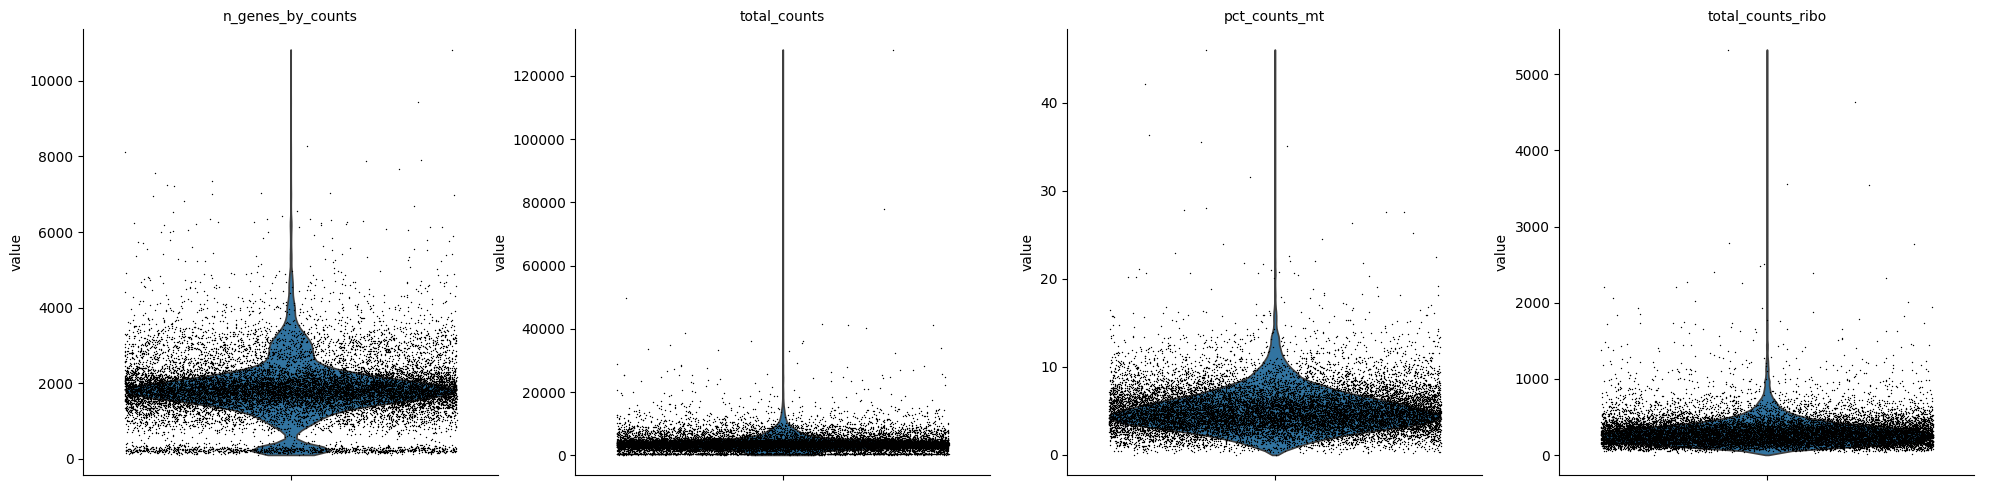

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","total_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

In [14]:
adata

AnnData object with n_obs × n_vars = 17147 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [55]:
adata.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
GTCATCCTCGTACCGA-1               2170                 7.682943        4504.0   
TCACATAAGCTAATCA-1               2122                 7.660585        4539.0   
GTGCTTACAATTGAGA-1               2211                 7.701652        4726.0   
TTCATTCAGTAACGAG-1                998                 6.906755        1670.0   
GCAGGCTTCAGGTCCA-1               1325                 7.189922        2770.0   
...                               ...                      ...           ...   
TTGTTCCCAGAGGGAG-1               1546                 7.344073        2921.0   
TTAGAAGCAATCCTGA-1               3690                 8.213653        9777.0   
TGGCGGTTCACTCAAA-1               2002                 7.602401        3639.0   
ATCCGTGAGCTTATGA-1               3372                 8.123558        9021.0   
GATCGCTCAGCTCATA-1               1921                 7.561122        3976.0   

                    log1p_total_counts  pct_counts_in_top_50_genes  \
GTCATCCTCGTACCGA-1            8.412943                   18.539076   
TCACATAAGCTAATCA-1            8.420682                   19.916281   
GTGCTTACAATTGAGA-1            8.461046                   17.160389   
TTCATTCAGTAACGAG-1            7.421177                   26.586826   
GCAGGCTTCAGGTCCA-1            7.926964                   27.292419   
...                                ...                         ...   
TTGTTCCCAGAGGGAG-1            7.980023                   22.252653   
TTAGAAGCAATCCTGA-1            9.187890                   17.172957   
TGGCGGTTCACTCAAA-1            8.199739                   19.016213   
ATCCGTGAGCTTATGA-1            9.107421                   19.709567   
GATCGCTCAGCTCATA-1            8.288283                   20.397384   

                    pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
GTCATCCTCGTACCGA-1                    25.666075                    35.523979   
TCACATAAGCTAATCA-1                    27.274730                    37.739590   
GTGCTTACAATTGAGA-1                    24.502751                    35.230639   
TTCATTCAGTAACGAG-1                    35.568862                    48.143713   
GCAGGCTTCAGGTCCA-1                    36.570397                    48.880866   
...                                         ...                          ...   
TTGTTCCCAGAGGGAG-1                    30.092434                    41.595344   
TTAGAAGCAATCCTGA-1                    24.158740                    33.077631   
TGGCGGTTCACTCAAA-1                    26.710635                    36.548502   
ATCCGTGAGCTTATGA-1                    26.050327                    34.940694   
GATCGCTCAGCTCATA-1                    28.043260                    39.059356   

                    pct_counts_in_top_500_genes  total_counts_mt  \
GTCATCCTCGTACCGA-1                    54.862345            209.0   
TCACATAAGCTAATCA-1                    56.972902            256.0   
GTGCTTACAATTGAGA-1                    55.628438            128.0   
TTCATTCAGTAACGAG-1                    70.179641            212.0   
GCAGGCTTCAGGTCCA-1                    70.216606            199.0   
...                                         ...              ...   
TTGTTCCCAGAGGGAG-1                    63.813762            174.0   
TTAGAAGCAATCCTGA-1                    49.299376            617.0   
TGGCGGTTCACTCAAA-1                    55.619676            241.0   
ATCCGTGAGCTTATGA-1                    51.623988            349.0   
GATCGCTCAGCTCATA-1                    58.953722            234.0   

                    log1p_total_counts_mt  pct_counts_mt  total_counts_ribo  \
GTCATCCTCGTACCGA-1               5.347107       4.640319              334.0   
TCACATAAGCTAATCA-1               5.549076       5.640008              333.0   
GTGCTTACAATTGAGA-1               4.859812       2.708421              286.0   
TTCATTCAGTAACGAG-1               5.361292      12.694611              108.0   
GCAGGCTTCAGGTCCA-1               5.298317    

In [47]:
ambimux = ambimux.set_index('Barcode')

In [52]:
np.sum(ambimux['rna_pct_mt'] > 0.1)

np.int64(3018)

In [40]:
np.sum(adata.obs['n_genes_by_counts'] < 250)

np.int64(723)

In [44]:
ambimux['best_singlet'].value_counts()

best_singlet
NWD372040    17245
NWD359498    12907
NWD252740    11386
NWD962229    10792
NWD617289    10493
NWD662575     9422
NWD389867     8734
NWD302076     3587
Name: count, dtype: int64